# EVALUATION LOOP

In [1]:
# ------------------------------------------------------------
# 0.  Imports & config – nothing here should clash with yours
# ------------------------------------------------------------
from tqdm import tqdm
import torch
from mathbert_encoder import MathBERTEncoder
import retriever_cosine as rc
# from import retrieve_top_k_cosine, retrieve_sample_k_cosine
from response_sampler import sample_responses_per_demo
from reward_aggregator import compute_demo_accuracy
from icl_model_wrapper import OpenAIICLModel
from grpo_optimizer import grpo_step
from datasets import load_dataset
from dotenv import load_dotenv
import os
from transformers import get_linear_schedule_with_warmup
from importlib import reload

reload(rc)

load_dotenv()

API_KEY = os.getenv("OPENAI_API_KEY")
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
K       = 3                # demos per query
NUM_SAMPLES = 5             # model completions per query
TEMPERATURE = 0.7           # keep same as training loop

# ------------------------------------------------------------
# 1.  Initialise encoder **in eval mode** (weights frozen)
# ------------------------------------------------------------
encoder = MathBERTEncoder(device=DEVICE, trainable=False)
encoder.eval()                                   # no grads!

icl_model = OpenAIICLModel(api_key=API_KEY,
                           model_name="gpt-4.1-nano",
                           temperature=TEMPERATURE)

# ------------------------------------------------------------
# 2.  Load/define the inference set
#     If you already saved a slice elsewhere, just load it.
# ------------------------------------------------------------
gsm8k_data = load_dataset("gsm8k", "main")["train"].select(range(256))  # slice first 200 examples
gsm8k_to_infer = load_dataset("gsm8k", "main")["train"] \
                     .select(range(20))          # ⬅ change as needed

# ------------------------------------------------------------
# 3.  Evaluation loop
# ------------------------------------------------------------
total, correct = 0, 0
all_losses     = []          # optional – to compare prompt quality

for idx in tqdm(range(len(gsm8k_to_infer)), desc="Baseline eval"):
    item       = gsm8k_to_infer[idx]
    Q_inf, A_gt = item["question"], item["answer"]

    # Build demo pool (everything except current query)
    demos = [(d["question"], d["answer"])
             for j, d in enumerate(gsm8k_data) if j != idx]

    # Encode query + candidate demos
    with torch.no_grad():
        q_emb     = encoder.encode([Q_inf], detach=True).squeeze(0)
        demo_embs = encoder.encode([q for (q, _) in demos], detach=True)

    # ------- ORIGINAL cosine retrieval -------------------------
    top_k, _ = rc.retrieve_top_k_cosine(
        q_emb, demo_embs, k=min(K, len(demos))
    )
    print(f"🔍 Top-K Indices: {top_k}")
    selected_demos = [demos[i] for i in top_k]          # length = 2

    # ------- Run the ICL model --------------------------------
    responses_nested = sample_responses_per_demo(
        demo_tuples = selected_demos,
        Q_inf       = Q_inf,
        icl_model   = icl_model,
        num_samples = NUM_SAMPLES,
        parallel=True
    )
    print(responses_nested)
    flat_responses = [r for demo_resps in responses_nested for r in demo_resps]
    acc = compute_demo_accuracy(flat_responses, A_gt)
    print(acc) 
    correct += acc
    total   += 1

baseline_acc = correct / total
print(f"\n📊  Baseline accuracy on GSM8K_to_infer: {baseline_acc:.3%}")


Baseline eval:   0%|          | 0/20 [00:00<?, ?it/s]

🔍 Top-K Indices: [81, 159, 35]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:   5%|▌         | 1/20 [00:01<00:27,  1.47s/it]

[['72', '72', '144', '72', '48 + (48 / 2) = 48 + 24 = 72'], ['96', '48 + (48/2) = 48 + 24 = 72', '72', '72', '72'], ['48 + 24 = 72', '48 + (48 ÷ 2) = 48 + 24 = 72', '48 + 24 = 72', '48 + 24 = 72', '48 + (48 ÷ 2) = 48 + 24 = 72']]
0.8666666666666667
🔍 Top-K Indices: [110, 147, 81]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  10%|█         | 2/20 [00:02<00:23,  1.32s/it]

[['10', '10', '10', '10', '10'], ['10', '10', '10', '10', '10'], ['10', '10', '10', '10', '10']]
1.0
🔍 Top-K Indices: [201, 73, 228]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  15%|█▌        | 3/20 [00:05<00:30,  1.79s/it]

[['25', '55', '50', '50', '25'], ['$55', '$55', '$55', '100 - (50 + 15 + 30) = 100 - 95 = 5', '$55'], ['$55', '25', '$35', '$35', '$55']]
1.0
🔍 Top-K Indices: [13, 93, 228]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  20%|██        | 4/20 [00:06<00:24,  1.51s/it]

[['36', '48', '42', '78', '54'], ['48', '48', '48', '48', '48'], ['48', '48', '48', '36', '54']]
0.06666666666666667
🔍 Top-K Indices: [93, 13, 113]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  25%|██▌       | 5/20 [00:07<00:20,  1.36s/it]

[['624', '624', '624', '624', '624'], ['312', '624', '624', '312', '312'], ['312', '312', '312', '312', '312']]
0.4666666666666667
🔍 Top-K Indices: [56, 161, 30]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  30%|███       | 6/20 [00:08<00:19,  1.43s/it]

[['70', '100', '70', 'Total flowers = yellow + purple + green = 10 + (80% of 10) + (25% of (10 + purple))\nPurple = 80% of 10 = 0.8 * 10 = 8\nGreen = 25% of (10 + 8) = 0.25 * 18 = 4.5\nTotal = 10 + 8 + 4.5 = 22.5', 'Total yellow flowers = 10  \nPurple flowers = 80% more than yellow = 10 + 0.8 * 10 = 10 + 8 = 18  \nTotal yellow and purple flowers = 10 + 18 = 28  \nGreen flowers = 25% of yellow and purple = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35'], ['150', '60', '78', '165', '225'], ['130', '160', '150', '90', '130']]
0.06666666666666667
🔍 Top-K Indices: [77, 64, 109]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  35%|███▌      | 7/20 [00:10<00:17,  1.37s/it]

[['48', '48', '48', '56', '48'], ['48', '48', '56', '48', '48'], ['48', '48', '48', '48', '48']]
0.8666666666666667
🔍 Top-K Indices: [89, 204, 60]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  40%|████      | 8/20 [00:11<00:15,  1.28s/it]

[['16', '8', '8', '16', '8'], ['8', '12', '8', '8', '16'], ['8', '8', '8', '8', '8']]
0.2
🔍 Top-K Indices: [97, 40, 191]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  45%|████▌     | 9/20 [00:12<00:13,  1.21s/it]

[['$41', '61', '$41', '$41', '61'], ['81', '$41', '61', '$41', '81'], ['59', '39', '59', '$41', '61']]
0.4
🔍 Top-K Indices: [81, 176, 161]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  50%|█████     | 10/20 [00:13<00:13,  1.31s/it]

[['$270', '$270', '$342.00', '252', '405'], ['$405', '$405', '$405', '$270', '90'], ['$270', '$270', '$405', '$405', '$270']]
0.06666666666666667
🔍 Top-K Indices: [23, 234, 248]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  55%|█████▌    | 11/20 [00:14<00:11,  1.24s/it]

[['422', '423.5', '423', '423', '423.5'], ['423', '423.5', '423.5', '423.5', '423.5'], ['423.5', '423.5', '423.5', '423.5', '423.5']]
0.0
🔍 Top-K Indices: [49, 238, 70]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  60%|██████    | 12/20 [00:15<00:09,  1.18s/it]

[['10', '4', '4', '5', '4'], ['4', '4', '6', '3', '5'], ['2', '4', '4', '4', '3']]
0.13333333333333333
🔍 Top-K Indices: [113, 75, 2]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  65%|██████▌   | 13/20 [00:17<00:08,  1.25s/it]

[['70', '80', '60 + ( (1/2)*60 - 5 ) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (0.5 * 60 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + ( (1/2) * 60 - 5 ) = 60 + (30 - 5) = 60 + 25 = 85'], ['165', '150', '135', '225', '92'], ['60 + (60 / 2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60 / 2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60 / 2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60 / 2 - 5) = 60 + (30 - 5) = 60 + 25 = 85']]
0.5333333333333333
🔍 Top-K Indices: [36, 49, 198]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  70%|███████   | 14/20 [00:18<00:07,  1.21s/it]

[['$30', '$30', '$26', '$30', '$24'], ['$30', '$30', '$30', '$30', '$30'], ['$30', '$30', '$30', '$30', '$30']]
0.0
🔍 Top-K Indices: [3, 93, 203]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  75%|███████▌  | 15/20 [00:19<00:06,  1.21s/it]

[['3', '3', '3', '3', '20 minutes / 8 pages = 2.5 minutes per page  \n120 pages * 2.5 minutes = 300 minutes  \n300 minutes / 60 = 5 hours'], ['20 hours', '20 hours', '20 hours', '30', '20 hours'], ['10', '3', '3', '3', '3']]
0.06666666666666667
🔍 Top-K Indices: [149, 95, 81]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  80%|████████  | 16/20 [00:20<00:04,  1.24s/it]

[['75000', '$157,500', '15000', '\\$105,000', '$35000'], ['$22500', '$15000', '$14,250', 'Profit per DVD = Selling price - Cost price = (6 * 2.5) - 6 = 15 - 6 = 9 dollars  \nNumber of DVDs sold in 20 weeks = 500 DVDs/day * 5 days/week * 20 weeks = 500 * 5 * 20 = 50,000 DVDs  \nTotal profit = 50,000 * 9 = 450,000 dollars', 'Profit per DVD = 2.5 * 6 - 6 = 15 - 6 = 9 dollars  \nNumber of DVDs sold in 20 weeks = 500 DVDs/day * 5 days/week * 20 weeks = 500 * 5 * 20 = 50,000 DVDs  \nTotal profit = 50,000 * 9 = 450,000 dollars'], ['75000', '7500', '60000', '7500', '7500']]
0.0
🔍 Top-K Indices: [40, 161, 127]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  85%|████████▌ | 17/20 [00:22<00:03,  1.27s/it]

[['1000', '1000', '1000', '1000', '1000'], ['714', '714', '714', '714', '714'], ['1000', '1000', "Mike's share = (2/7) * 2500 = 714.29\nAfter buying the shirt, Mike's remaining amount = 714.29 - 200 = 514.29", "Mike's share = (2/7) * $2500 = $714.29  \nAfter spending $200, Mike's remaining amount = $714.29 - $200 = 514.29", "Mike's share = (2/7) * 2500 = 714.29  \nMike's remaining amount after buying the shirt = 714.29 - 200 = 514.29"]]
0.0
🔍 Top-K Indices: [19, 38, 236]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  90%|█████████ | 18/20 [00:23<00:02,  1.38s/it]

[['27', '44', '51', '26 - 4 - 6 = 16 pink hard hats remaining  \n15 - (2 × 6) = 3 green hard hats remaining  \n24 yellow hard hats remaining  \n\nTotal remaining hard hats = 16 + 3 + 24 = 43', '26 - 4 - 6 = 16 pink hard hats remaining  \n15 - 12 = 3 green hard hats remaining (since John took away 6, which is twice 3)  \n24 yellow hard hats remaining (none taken away)  \nTotal remaining = 16 + 3 + 24 = 43'], ['59', '69', '59', '56', '54'], ['54', '69', '64', '49', '64']]
0.13333333333333333
🔍 Top-K Indices: [70, 49, 140]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  95%|█████████▌| 19/20 [00:25<00:01,  1.58s/it]

[['9', '9', '9', '10', '9'], ['15', '15', '15', '15', '15'], ['10', '10', '12', '10', '10']]
0.0
🔍 Top-K Indices: [207, 64, 65]
[INFO] Launching 15 parallel inference tasks...


Baseline eval: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

[['44', '22.4', '16', '28', '20 miles each way, so 40 miles per day for 5 days: 40 * 5 = 200 miles.  \nAdd weekend ride: 200 miles.  \nTotal miles biked: 200 + 200 = 400 miles.  \nTime = Distance / Speed = 400 / 25 = 16 hours.'], ['40', '24', '12', '40', '40'], ['50', '26', '40', '18', '34']]
0.13333333333333333

📊  Baseline accuracy on GSM8K_to_infer: 30.000%


# TRAINING LOOP

In [11]:
from tqdm import tqdm
import torch
from mathbert_encoder import MathBERTEncoder
import retriever_cosine as rc
# from import retrieve_top_k_cosine, retrieve_sample_k_cosine
from response_sampler import sample_responses_per_demo
from reward_aggregator import compute_demo_accuracy
from icl_model_wrapper import OpenAIICLModel
from grpo_optimizer import grpo_step
from datasets import load_dataset
from dotenv import load_dotenv
import os
from transformers import get_linear_schedule_with_warmup
from importlib import reload

reload(rc)

load_dotenv()

# === Settings ===
API_KEY = os.getenv("OPENAI_API_KEY")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
K = 53
NUM_SAMPLES_PER_DEMO = 3
LEARNING_RATE =  1e-5
MAX_STEPS = 10
TEMPERATURE = 0.7

# === Init ===
encoder = MathBERTEncoder(device=DEVICE, trainable=True)
encoder.train()

icl_model = OpenAIICLModel(api_key=API_KEY, model_name="gpt-4.1-nano", temperature=TEMPERATURE)
optimizer = torch.optim.Adam(encoder.parameters(), lr=LEARNING_RATE)

gsm8k_data = load_dataset('gsm8k', 'main')['train']
gsm8k_data = gsm8k_data.select(range(256))  # slice first 200 examples
gsm8k_data_to_infer = gsm8k_data.select(range(0,20))  # slice first 200 examples

# === Training Loop ===
epoch_wide_rewards = []
for step in tqdm(range(MAX_STEPS), desc="Training Steps"):
    print(f"\n=== Training Step {step+1} ===")
    epoch_wide_reward = []
    for inference_index in tqdm(range(len(gsm8k_data_to_infer)), desc="Examples"):
        inference_item = gsm8k_data_to_infer[inference_index]
        demo_pool = [d for idx, d in enumerate(gsm8k_data) if idx != inference_index]

        Q_inf = inference_item["question"]
        A_gt = inference_item["answer"]
        demos = [(d["question"], d["answer"]) for d in demo_pool]

        q_emb = encoder.encode([Q_inf], detach=False).squeeze(0)
        
        # SWITCHING TO BATCH ENCODE
        # demo_embs = encoder.encode([q for (q, a) in demos], detach=False)
        demo_questions = [q for (q, a) in demos]
        demo_embs = encoder.batched_encode(demo_questions, batch_size=16, detach=False)

        
        top_k_indices, _ = rc.retrieve_top_k_cosine(q_emb, demo_embs, k=min(K, len(demos)))
        print("-------Question---------")
        print(Q_inf)
        print(f"\n🧠 Inference Index {inference_index}")
        print(f"🔍 Top-K Indices: {top_k_indices}")
        
        top_k_indices, similarities = rc.retrieve_sample_k_cosine(q_emb, demo_embs, k=min(K, len(demos)))
        selected_demos = [demos[i] for i in top_k_indices]



        all_responses = sample_responses_per_demo(
            demo_tuples=selected_demos,
            Q_inf=Q_inf,
            icl_model=icl_model,
            num_samples=NUM_SAMPLES_PER_DEMO,
            parallel=True
        )

        rewards = []
        for i, responses in enumerate(all_responses):
            reward = compute_demo_accuracy(responses, A_gt)
            rewards.append(reward)
            # print(f"    Demo {i} | Reward: {reward:.2f}")

        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)

        loss = grpo_step(
            rewards,
            similarities,
            q_emb,
            demo_embs,
            optimizer
        )
        epoch_wide_reward.append(rewards.mean())
        print(f"✅ Rewards: {rewards.mean():.4f}")
        print(f"✅ Loss: {loss:.4f}")
    epoch_wide_rewards.append(epoch_wide_reward)


Training Steps:   0%|          | 0/10 [00:00<?, ?it/s]


=== Training Step 1 ===


-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [204, 159, 26, 8, 136, 32, 30, 168, 89, 145, 127, 251, 19, 215, 144, 60, 56, 160, 227, 112, 71, 122, 103, 177, 81, 57, 107, 104, 161, 85, 61, 35, 1, 238, 226, 4, 167, 110, 234, 121, 64, 51, 74, 5, 147, 181, 207, 69, 72, 149, 247, 15, 137]
[INFO] Launching 159 parallel inference tasks...


tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.6667, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([-3.7668,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354,
         0.3354,  0.3354,  0.3354, -3.7668,  0.3354,  0.3354,  0.3354,  0.3354,
         0.3354, -1.0320,  0.3354,  0.3354, -1.0320,  0.3354,  0.3354,  0.3354,
         0.3354,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354, -1.0320,
         0.3354,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354,
        -3.7668, -1.0320,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354,  0.3354,
         0.3354,  0.335

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [251, 136, 77, 15, 73, 82, 245, 56, 228, 129, 22, 65, 2, 112, 51, 105, 101, 154, 30, 83, 131, 120, 161, 94, 157, 64, 86, 40, 23

tensor([1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 0.6667, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 0.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.3333, 0.6667, 0.0000, 0.6667, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4682,  0.4682, -0.6598,  0.4682,  0.4682, -0.6598, -2.9158,  0.4682,
         0.4682,  0.4682,  0.4682,  0.4682,  0.4682,  0.4682,  0.4682,  0.4682,
         0.4682,  0.4682,  0.4682,  0.4682,  0.4682,  0.4682,  0.4682, -1.7878,
        -2.9158,  0.4682,  0.4682,  0.4682, -2.9158,  0.4682,  0.4682,  0.4682,
         0.4682, -0.6598,  0.4682,  0.4682,  0.4682,  0.4682, -0.6598,  0.4682,
         0.4682,  0.4682,  0.4682,  0.4682,  0.4682,  0.4682, -1.7878, -0.6598,
        -2.9158, -0.659

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 0.0000
✅ Loss: -0.0000
-------Question---------
James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?

🧠 Inference Index 4
🔍 Top-K Indices: [221, 82, 89, 157, 225, 59, 161, 93, 178, 251, 211, 92, 240, 14, 176, 137, 150, 29, 51, 207, 202, 136, 232, 15, 208, 2, 145, 72, 112, 110, 228, 213, 113, 63, 249, 244, 134, 204, 99, 22, 84, 191, 149, 117, 187, 33, 217, 65, 133, 140, 61, 73, 45]
[INFO] Launching 159 parallel inference tasks.

tensor([0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.3333, 0.0000, 0.6667, 0.3333, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([-0.4886, -0.4886,  0.6373,  2.8892, -0.4886, -0.4886, -0.4886, -0.4886,
        -0.4886,  0.6373, -0.4886,  0.6373, -0.4886,  1.7632,  0.6373,  0.6373,
        -0.4886, -0.4886, -0.4886, -0.4886, -0.4886, -0.4886,  0.6373, -0.4886,
         2.8892, -0.4886, -0.4886, -0.4886, -0.4886, -0.4886, -0.4886, -0.4886,
        -0.4886, -0.4886,  2.8892, -0.4886, -0.4886, -0.4886,  1.7632, -0.4886,
        -0.4886, -0.4886, -0.4886,  2.8892, -0.4886, -0.4886, -0.4886, -0.4886,
        -0.4886, -0.488

tensor([0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.6667, 0.6667, 0.3333, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.6667, 0.0000, 1.0000, 1.0000,
        0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000],
       device='cuda:0')
tensor([-0.6996, -0.6996,  0.1832,  0.1832, -0.6996, -0.6996,  1.9489, -0.6996,
        -0.6996,  0.1832, -0.6996, -0.6996, -0.6996, -0.6996, -0.6996, -0.6996,
        -0.6996,  1.9489,  1.9489,  1.0661,  1.0661,  0.1832,  1.9489, -0.6996,
        -0.6996, -0.6996,  1.9489, -0.6996, -0.6996,  0.1832, -0.6996,  1.0661,
        -0.6996, -0.6996, -0.6996,  0.1832, -0.6996, -0.6996,  1.9489, -0.6996,
        -0.6996,  1.0661, -0.6996,  1.9489,  1.9489, -0.6996,  0.1832,  0.1832,
        -0.6996, -0.699

tensor([0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.6667, 0.0000,
        1.0000, 0.6667, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 0.3333, 1.0000,
        1.0000, 0.6667, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.3333, 0.3333, 0.6667, 1.0000, 1.0000, 0.0000, 1.0000],
       device='cuda:0')
tensor([-1.6145,  0.5796,  0.5796,  0.5796,  0.5796,  0.5796, -1.6145,  0.5796,
        -0.5175,  0.5796,  0.5796,  0.5796,  0.5796,  0.5796,  0.5796, -2.7115,
        -0.5175, -2.7115,  0.5796, -0.5175,  0.5796,  0.5796, -0.5175,  0.5796,
         0.5796, -1.6145,  0.5796,  0.5796, -0.5175,  0.5796,  0.5796, -0.5175,
         0.5796,  0.5796,  0.5796,  0.5796,  0.5796, -1.6145,  0.5796,  0.5796,
         0.5796,  0.5796,  0.5796,  0.5796,  0.5796,  0.5796, -1.6145, -1.6145,
        -0.5175,  0.579

tensor([0.0000, 0.3333, 0.0000, 1.0000, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.6667, 1.0000, 0.0000, 0.3333, 0.3333,
        1.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 1.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.3333],
       device='cuda:0')
tensor([-0.7810,  0.1816, -0.7810,  2.1069,  1.1443,  0.1816, -0.7810, -0.7810,
        -0.7810,  1.1443, -0.7810, -0.7810, -0.7810,  0.1816,  1.1443, -0.7810,
         0.1816, -0.7810, -0.7810, -0.7810,  2.1069, -0.7810,  1.1443,  2.1069,
        -0.7810,  0.1816,  0.1816,  2.1069, -0.7810,  0.1816,  0.1816, -0.7810,
        -0.7810, -0.7810,  0.1816,  2.1069,  1.1443, -0.7810, -0.7810, -0.7810,
         0.1816,  0.1816, -0.7810, -0.7810, -0.7810,  2.1069, -0.7810, -0.7810,
        -0.7810, -0.781

tensor([0.6667, 0.3333, 1.0000, 1.0000, 0.6667, 0.6667, 1.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000,
        0.6667, 0.6667, 0.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000,
        1.0000, 0.6667, 0.6667, 0.6667, 1.0000, 0.3333, 1.0000, 1.0000, 0.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 0.3333, 0.6667, 1.0000, 0.6667, 0.0000, 0.6667, 0.0000],
       device='cuda:0')
tensor([-0.0834, -0.9675,  0.8007,  0.8007, -0.0834, -0.0834,  0.8007,  0.8007,
        -1.8516,  0.8007, -1.8516,  0.8007,  0.8007,  0.8007, -1.8516,  0.8007,
         0.8007, -1.8516, -0.0834, -0.0834, -1.8516,  0.8007,  0.8007,  0.8007,
        -0.9675,  0.8007,  0.8007,  0.8007, -0.0834, -0.0834, -0.0834,  0.8007,
        -0.9675,  0.8007,  0.8007, -1.8516, -0.0834,  0.8007,  0.8007,  0.8007,
         0.8007, -1.8516,  0.8007,  0.8007, -0.0834,  0.8007, -0.9675, -0.0834,
         0.8007, -0.083

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,  4.0438,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,  4.0438,
        -0.2426, -0.2426, -0.2426,  4.0438, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.242

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000,
        0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4480, -0.4480, -0.4480, -0.4480, -0.4480,  1.5306, -0.4480, -0.4480,
        -0.4480,  1.5306, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480,
         1.5306, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480,
         1.5306,  3.5092, -0.4480,  1.5306, -0.4480, -0.4480,  1.5306, -0.4480,
        -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480,  3.5092, -0.4480,
        -0.4480,  1.5306, -0.4480,  1.5306, -0.4480, -0.4480, -0.4480, -0.4480,
        -0.4480, -0.448

tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 1.9717, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,
         1.9717, -0.3000,  1.9717, -0.3000, -0.3000, -0.3000,  4.2435, -0.3000,
        -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,  4.2435, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.300

tensor([0.3333, 1.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.6667, 0.0000, 0.6667, 0.6667, 0.0000, 1.0000, 0.0000,
        0.0000, 0.6667, 0.0000, 0.3333, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.6667, 1.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.6667, 0.0000, 0.6667,
        1.0000, 1.0000, 0.0000, 1.0000, 0.3333, 1.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([-0.1226,  1.5021, -0.9350, -0.9350, -0.9350, -0.1226, -0.9350, -0.9350,
        -0.9350, -0.9350, -0.1226,  0.6898, -0.9350,  0.6898,  0.6898, -0.9350,
         1.5021, -0.9350, -0.9350,  0.6898, -0.9350, -0.1226,  0.6898, -0.1226,
        -0.9350, -0.9350, -0.9350,  1.5021,  1.5021,  0.6898,  1.5021, -0.9350,
        -0.9350, -0.1226, -0.9350, -0.1226,  1.5021,  1.5021, -0.9350, -0.9350,
         1.5021, -0.9350,  0.6898, -0.9350,  0.6898,  1.5021,  1.5021, -0.9350,
         1.5021, -0.122

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893,
        -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893,  1.2441,  4.3111,
        -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893,
        -0.2893,  2.7776,  1.2441, -0.2893, -0.2893, -0.2893,  4.3111, -0.2893,
        -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893,
        -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893,
        -0.2893, -0.289

tensor([0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.6667, 0.3333, 0.0000, 0.6667, 0.0000, 1.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 1.0000, 0.0000, 0.6667,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6667, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 0.2453, -0.6833,  0.2453, -0.6833, -0.6833,  2.1025, -0.6833, -0.6833,
         2.1025,  1.1739,  0.2453, -0.6833,  1.1739, -0.6833,  2.1025,  0.2453,
        -0.6833, -0.6833, -0.6833, -0.6833, -0.6833, -0.6833,  1.1739, -0.6833,
         0.2453, -0.6833, -0.6833,  0.2453, -0.6833, -0.6833,  1.1739, -0.6833,
        -0.6833,  2.1025, -0.6833,  1.1739,  2.1025, -0.6833, -0.6833, -0.6833,
         2.1025,  0.2453, -0.6833, -0.6833, -0.6833, -0.6833, -0.6833,  1.1739,
        -0.6833,  1.173

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,  7.1427,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.6667,
        0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034,
        -0.3034, -0.3034,  1.3045, -0.3034, -0.3034,  4.5203, -0.3034, -0.3034,
        -0.3034,  2.9124,  2.9124, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034,
        -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034,
        -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034,
         2.9124, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034, -0.3034,
        -0.3034, -0.303

tensor([0.3333, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 1.1561, -0.3384,  4.1450, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,
        -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,  1.1561,
        -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,
        -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,  2.6505, -0.3384,
        -0.3384, -0.3384,  1.1561, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,
        -0.3384, -0.3384,  4.1450, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,
         1.1561, -0.338

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240,
        -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240,
        -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240,
        -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240,
         4.8643, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240,  1.4721,
        -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240, -0.2240,
        -0.2240, -0.224

Training Steps:  10%|█         | 1/10 [02:51<25:40, 171.21s/it]

tensor([0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.6667, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.3333, 0.0000,
        0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333,
        0.6667, 0.0000, 0.0000, 0.3333, 1.0000, 0.6667, 0.6667, 1.0000, 1.0000,
        0.3333, 0.3333, 0.6667, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.3333,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 1.1326, -0.8038, -0.8038, -0.8038, -0.8038,  2.1008, -0.8038,  1.1326,
        -0.8038, -0.8038,  0.1644, -0.8038, -0.8038,  0.1644,  1.1326, -0.8038,
         0.1644, -0.8038, -0.8038,  1.1326, -0.8038, -0.8038, -0.8038, -0.8038,
        -0.8038,  1.1326,  0.1644,  1.1326, -0.8038, -0.8038,  0.1644,  2.1008,
         1.1326,  1.1326,  2.1008,  2.1008,  0.1644,  0.1644,  1.1326, -0.8038,
         0.1644,  0.1644, -0.8038, -0.8038,  0.1644,  0.1644, -0.8038, -0.8038,
        -0.8038, -0.803

-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [136, 147, 228, 93, 201, 79, 17, 112, 85, 74, 144, 139, 146, 51, 185, 119, 161, 64, 14, 232, 109, 235, 194, 101, 63, 0, 128, 250, 118, 160, 221, 184, 134, 217, 122, 81, 187, 52, 157, 15, 13, 103, 69, 59, 156, 220, 163, 105, 104, 208, 113, 150, 4]
[INFO] Launching 159 parallel inference tasks...


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.3333, 1.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.3333],
       device='cuda:0')
tensor([ 0.3714,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,
         0.3714,  0.3714,  0.3714,  0.3714, -1.0347,  0.3714, -1.0347,  0.3714,
         0.3714,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,
         0.3714,  0.3714, -1.0347,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,
         0.3714,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,  0.3714,
         0.3714, -3.8468,  0.3714, -2.4407,  0.3714, -1.0347,  0.3714,  0.3714,
         0.3714, -3.846

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [228, 15, 239, 75, 50, 154, 203, 131, 110, 201, 217, 112, 120, 33, 77, 184, 147, 5, 160, 202, 196, 152, 170, 104, 99, 151, 48, 

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333,
        1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.3333, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
       device='cuda:0')
tensor([ 0.4388,  0.4388,  0.4388,  0.4388,  0.4388,  0.4388, -0.7241,  0.4388,
         0.4388, -3.0498,  0.4388,  0.4388, -1.8869,  0.4388,  0.4388,  0.4388,
         0.4388, -1.8869,  0.4388, -0.7241,  0.4388,  0.4388,  0.4388,  0.4388,
         0.4388,  0.4388,  0.4388, -1.8869, -3.0498,  0.4388,  0.4388,  0.4388,
         0.4388, -3.0498,  0.4388,  0.4388,  0.4388,  0.4388,  0.4388,  0.4388,
         0.4388,  0.4388,  0.4388,  0.4388,  0.4388,  0.4388,  0.4388, -1.8869,
         0.4388,  0.438

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374,  7.1427, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.3333, 0.0000, 0.6667, 0.3333,
        0.0000, 0.3333, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4756, -0.4756, -0.4756,  2.6755, -0.4756,  2.6755, -0.4756, -0.4756,
        -0.4756, -0.4756, -0.4756, -0.4756,  0.5747,  2.6755,  0.5747, -0.4756,
         1.6251,  0.5747, -0.4756,  0.5747, -0.4756, -0.4756,  1.6251, -0.4756,
         0.5747, -0.4756, -0.4756, -0.4756, -0.4756, -0.4756, -0.4756, -0.4756,
        -0.4756, -0.4756, -0.4756,  2.6755, -0.4756, -0.4756, -0.4756, -0.4756,
         2.6755, -0.4756, -0.4756, -0.4756, -0.4756, -0.4756, -0.4756, -0.4756,
        -0.4756, -0.475

tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 1.0000, 0.3333, 0.0000,
        0.0000, 0.6667, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 1.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.6667,
        1.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.6667],
       device='cuda:0')
tensor([ 1.8508, -0.7081, -0.7081, -0.7081,  0.1448,  0.9978,  1.8508,  0.1448,
        -0.7081, -0.7081,  0.9978,  0.9978, -0.7081, -0.7081, -0.7081, -0.7081,
        -0.7081, -0.7081,  0.1448, -0.7081, -0.7081,  1.8508,  0.1448, -0.7081,
         1.8508, -0.7081,  0.9978,  1.8508,  0.1448, -0.7081, -0.7081, -0.7081,
        -0.7081, -0.7081, -0.7081, -0.7081, -0.7081, -0.7081,  1.8508, -0.7081,
        -0.7081, -0.7081, -0.7081, -0.7081,  1.8508, -0.7081,  1.8508,  1.8508,
         0.1448,  0.144

tensor([1.0000, 0.6667, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.3333, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4339, -1.0034,  0.4339,  0.4339, -2.4408,  0.4339,  0.4339,  0.4339,
         0.4339,  0.4339,  0.4339, -1.0034, -2.4408,  0.4339,  0.4339,  0.4339,
         0.4339,  0.4339,  0.4339, -2.4408,  0.4339, -2.4408,  0.4339,  0.4339,
         0.4339,  0.4339,  0.4339,  0.4339, -3.8781,  0.4339, -1.0034,  0.4339,
         0.4339,  0.4339,  0.4339,  0.4339,  0.4339,  0.4339,  0.4339,  0.4339,
         0.4339,  0.4339,  0.4339,  0.4339, -1.0034,  0.4339, -1.0034,  0.4339,
         0.4339,  0.433

tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.0000, 0.0000, 1.0000,
        0.3333, 0.3333, 0.0000, 0.3333, 0.3333, 0.3333, 0.6667, 0.0000, 0.6667,
        0.6667, 0.3333, 0.0000, 0.3333, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 0.0000, 0.6667, 0.0000, 1.0000, 0.6667, 0.3333, 0.0000,
        0.0000, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        1.0000, 0.6667, 0.6667, 0.0000, 0.6667, 0.6667, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 1.8956, -0.9212, -0.9212, -0.9212,  0.9567,  0.0177, -0.9212, -0.9212,
         1.8956,  0.0177,  0.0177, -0.9212,  0.0177,  0.0177,  0.0177,  0.9567,
        -0.9212,  0.9567,  0.9567,  0.0177, -0.9212,  0.0177,  1.8956,  0.0177,
        -0.9212, -0.9212, -0.9212,  0.9567, -0.9212, -0.9212,  0.9567, -0.9212,
         1.8956,  0.9567,  0.0177, -0.9212, -0.9212,  1.8956,  0.0177, -0.9212,
        -0.9212, -0.9212, -0.9212, -0.9212,  0.0177,  1.8956,  0.9567,  0.9567,
        -0.9212,  0.956

tensor([1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.6667, 0.3333, 1.0000, 1.0000, 0.6667, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 0.0000, 0.0000, 0.6667, 0.3333, 1.0000, 0.6667,
        0.3333, 0.3333, 1.0000, 0.3333, 1.0000, 1.0000, 0.3333, 0.6667, 0.6667,
        1.0000, 0.0000, 1.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.6667,
        0.3333, 1.0000, 1.0000, 1.0000, 0.3333, 0.3333, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.8519,  0.8519, -1.7528,  0.8519,  0.8519,  0.8519,  0.8519,  0.8519,
         0.8519,  0.8519, -0.0164, -0.8846,  0.8519,  0.8519, -0.0164, -1.7528,
         0.8519,  0.8519,  0.8519,  0.8519, -0.0164, -1.7528, -1.7528, -0.0164,
        -0.8846,  0.8519, -0.0164, -0.8846, -0.8846,  0.8519, -0.8846,  0.8519,
         0.8519, -0.8846, -0.0164, -0.0164,  0.8519, -1.7528,  0.8519, -0.8846,
        -1.7528, -1.7528,  0.8519, -1.7528, -0.0164, -0.8846,  0.8519,  0.8519,
         0.8519, -0.884

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374,  7.1427, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.6667,
        0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([-0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979,
        -0.3979, -0.3979,  1.9452, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979,
        -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979,
        -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979,
        -0.3979,  1.9452, -0.3979,  4.2883, -0.3979, -0.3979,  1.9452, -0.3979,
         1.9452, -0.3979, -0.3979, -0.3979,  1.9452, -0.3979,  1.9452, -0.3979,
        -0.3979, -0.397

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374,  7.1427, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([1.0000, 0.0000, 1.0000, 0.3333, 0.0000, 0.3333, 1.0000, 0.6667, 0.6667,
        0.3333, 1.0000, 1.0000, 0.3333, 0.0000, 1.0000, 1.0000, 0.3333, 0.3333,
        0.3333, 0.0000, 0.6667, 0.3333, 0.3333, 1.0000, 1.0000, 0.0000, 1.0000,
        0.3333, 1.0000, 0.0000, 0.3333, 0.3333, 0.0000, 1.0000, 0.3333, 0.6667,
        1.0000, 0.3333, 0.0000, 0.3333, 1.0000, 0.6667, 0.3333, 1.0000, 0.3333,
        0.0000, 1.0000, 0.6667, 0.3333, 1.0000, 1.0000, 1.0000, 0.0000],
       device='cuda:0')
tensor([ 1.1693, -1.4129,  1.1693, -0.5522, -1.4129, -0.5522,  1.1693,  0.3086,
         0.3086, -0.5522,  1.1693,  1.1693, -0.5522, -1.4129,  1.1693,  1.1693,
        -0.5522, -0.5522, -0.5522, -1.4129,  0.3086, -0.5522, -0.5522,  1.1693,
         1.1693, -1.4129,  1.1693, -0.5522,  1.1693, -1.4129, -0.5522, -0.5522,
        -1.4129,  1.1693, -0.5522,  0.3086,  1.1693, -0.5522, -1.4129, -0.5522,
         1.1693,  0.3086, -0.5522,  1.1693, -0.5522, -1.4129,  1.1693,  0.3086,
        -0.5522,  1.169

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237,  5.7036, -0.2237,  3.7279, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,  1.7521,
        -0.2237, -0.223

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.6667,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 1.0000, 0.6667, 0.0000, 1.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.5431, -0.5431,  0.4849, -0.5431, -0.5431,  1.5129, -0.5431, -0.5431,
         1.5129, -0.5431, -0.5431,  0.4849, -0.5431, -0.5431, -0.5431, -0.5431,
        -0.5431, -0.5431, -0.5431, -0.5431,  0.4849, -0.5431,  1.5129,  2.5409,
         1.5129, -0.5431,  2.5409,  1.5129, -0.5431, -0.5431, -0.5431,  1.5129,
        -0.5431, -0.5431, -0.5431,  2.5409, -0.5431, -0.5431, -0.5431, -0.5431,
         2.5409, -0.5431, -0.5431, -0.5431, -0.5431,  0.4849, -0.5431, -0.5431,
        -0.5431, -0.543

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 0.0000
✅ Loss: -0.0000
-------Question---------
The profit from a business transaction is shared among 2 business partners, Mike and Johnson in the ratio 2:5 respectively. If Johnson got $2500, how much will Mike have after spending some of his share on a shirt that costs $200?

🧠 Inference Index 16
🔍 Top-K Indices: [6, 56, 61, 50, 176, 94, 122, 101, 118, 237, 82, 64, 55, 197, 159, 240, 203, 105, 168, 128, 222, 147, 109, 194, 51, 73, 233, 232, 52, 212, 40, 88, 65, 180, 38, 157

tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000],
       device='cuda:0')
tensor([-0.3979,  1.9452, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979,
        -0.3979, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979,  1.9452,  1.9452,
        -0.3979, -0.3979, -0.3979, -0.3979, -0.3979,  1.9452, -0.3979, -0.3979,
        -0.3979, -0.3979, -0.3979, -0.3979,  1.9452, -0.3979, -0.3979, -0.3979,
        -0.3979, -0.3979,  1.9452, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979,
        -0.3979, -0.3979,  1.9452, -0.3979, -0.3979, -0.3979, -0.3979, -0.3979,
        -0.3979, -0.397

tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.6667, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
        0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4713,  1.1939, -0.4713, -0.4713, -0.4713, -0.4713, -0.4713, -0.4713,
        -0.4713,  2.8590, -0.4713, -0.4713, -0.4713, -0.4713, -0.4713,  2.8590,
         2.8590, -0.4713, -0.4713, -0.4713, -0.4713, -0.4713, -0.4713, -0.4713,
        -0.4713, -0.4713,  2.8590,  1.1939,  1.1939, -0.4713, -0.4713, -0.4713,
         1.1939, -0.4713, -0.4713, -0.4713, -0.4713, -0.4713,  1.1939, -0.4713,
        -0.4713,  1.1939, -0.4713, -0.4713, -0.4713,  1.1939, -0.4713, -0.4713,
        -0.4713, -0.471

tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2511, -0.2511, -0.2511,  4.7393, -0.2511, -0.2511, -0.2511, -0.2511,
        -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511,  4.7393, -0.2511,
        -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511,
        -0.2511,  1.4124, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511,
        -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511,
        -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511, -0.2511,  1.4124,
        -0.2511, -0.251

Training Steps:  20%|██        | 2/10 [05:33<22:06, 165.85s/it]

tensor([0.3333, 0.6667, 0.0000, 1.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000, 0.0000, 1.0000, 0.3333, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000, 1.0000, 0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333,
        0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.3333, 0.6667, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.3333, 0.0000],
       device='cuda:0')
tensor([ 0.2102,  1.2227, -0.8024,  2.2353, -0.8024, -0.8024,  0.2102,  2.2353,
        -0.8024, -0.8024, -0.8024,  0.2102,  2.2353, -0.8024, -0.8024, -0.8024,
         0.2102,  0.2102, -0.8024, -0.8024,  2.2353,  0.2102,  0.2102, -0.8024,
         0.2102, -0.8024,  0.2102, -0.8024,  2.2353, -0.8024,  1.2227, -0.8024,
         0.2102, -0.8024,  0.2102,  0.2102, -0.8024,  0.2102, -0.8024,  0.2102,
         0.2102, -0.8024,  0.2102,  1.2227,  0.2102, -0.8024, -0.8024, -0.8024,
        -0.8024,  2.235

-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [88, 233, 240, 128, 228, 182, 49, 98, 136, 215, 149, 81, 161, 30, 83, 101, 45, 220, 154, 12, 90, 133, 163, 207, 8, 47, 115, 234, 242, 113, 241, 164, 60, 14, 142, 40, 19, 226, 77, 109, 85, 2, 186, 120, 15, 146, 139, 251, 57, 48, 160, 205, 69]
[INFO] Launching 159 parallel inference tasks...


tensor([1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.0000, 0.6667, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 0.6667, 0.3333, 1.0000, 0.6667, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.3333, 1.0000,
        1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.5406,  0.5406, -2.3244,  0.5406,  0.5406,  0.5406,  0.5406,  0.5406,
         0.5406,  0.5406,  0.5406,  0.5406,  0.5406, -0.4144, -2.3244, -0.4144,
         0.5406,  0.5406,  0.5406, -2.3244,  0.5406,  0.5406, -0.4144, -1.3694,
         0.5406, -0.4144,  0.5406,  0.5406,  0.5406,  0.5406,  0.5406,  0.5406,
         0.5406,  0.5406,  0.5406,  0.5406,  0.5406,  0.5406,  0.5406, -2.3244,
        -2.3244,  0.5406, -2.3244, -1.3694,  0.5406,  0.5406,  0.5406, -1.3694,
         0.5406,  0.540

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [25, 120, 63, 109, 22, 40, 233, 11, 228, 158, 112, 152, 219, 191, 4, 121, 99, 157, 243, 202, 235, 239, 159, 194, 167, 211, 207,

tensor([1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 0.6667,
        1.0000, 0.3333, 1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000,
        1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.5256, -0.9406,  0.5256, -0.9406,  0.5256,  0.5256,  0.5256,  0.5256,
         0.5256, -0.9406,  0.5256,  0.5256,  0.5256, -0.9406,  0.5256, -0.9406,
         0.5256, -0.9406,  0.5256, -2.4068,  0.5256, -0.9406,  0.5256, -0.9406,
         0.5256,  0.5256,  0.5256,  0.5256,  0.5256,  0.5256, -0.9406,  0.5256,
         0.5256,  0.5256, -0.9406,  0.5256,  0.5256,  0.5256, -2.4068,  0.5256,
         0.5256,  0.5256,  0.5256,  0.5256, -2.4068,  0.5256,  0.5256, -3.8730,
         0.5256,  0.525

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 0.0000
✅ Loss: -0.0000
-------Question---------
James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?

🧠 Inference Index 4
🔍 Top-K Indices: [232, 120, 207, 73, 93, 196, 253, 135, 159, 6, 171, 29, 199, 101, 145, 35, 40, 60, 38, 86, 210, 21, 218, 49, 84, 72, 36, 14, 87, 140, 51, 53, 117, 204, 23, 215, 173, 8, 19, 44, 89, 203, 24, 13, 230, 100, 211, 80, 22, 247, 115, 149, 129]
[INFO] Launching 159 parallel inference tasks...


tensor([0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4886,  1.7632, -0.4886, -0.4886, -0.4886, -0.4886, -0.4886, -0.4886,
         2.8892, -0.4886, -0.4886, -0.4886,  0.6373, -0.4886,  1.7632, -0.4886,
        -0.4886, -0.4886, -0.4886, -0.4886, -0.4886,  0.6373,  0.6373, -0.4886,
        -0.4886, -0.4886,  1.7632, -0.4886,  2.8892, -0.4886, -0.4886, -0.4886,
        -0.4886,  1.7632, -0.4886,  0.6373, -0.4886, -0.4886, -0.4886, -0.4886,
        -0.4886, -0.4886, -0.4886, -0.4886, -0.4886,  2.8892, -0.4886,  1.7632,
        -0.4886, -0.488

tensor([0.0000, 0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000,
        0.0000, 0.6667, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.3333, 0.3333, 1.0000, 1.0000, 0.3333, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.6667, 0.0000, 0.3333, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.7081, -0.7081,  0.9978, -0.7081,  0.1448, -0.7081, -0.7081, -0.7081,
         1.8508, -0.7081,  0.9978, -0.7081, -0.7081, -0.7081, -0.7081,  0.1448,
         1.8508, -0.7081, -0.7081,  0.9978, -0.7081,  0.9978, -0.7081, -0.7081,
        -0.7081, -0.7081, -0.7081, -0.7081,  1.8508, -0.7081,  0.1448,  0.1448,
         1.8508,  1.8508,  0.1448, -0.7081,  1.8508, -0.7081,  1.8508, -0.7081,
         1.8508, -0.7081, -0.7081, -0.7081, -0.7081, -0.7081,  0.1448,  0.9978,
        -0.7081,  0.144

tensor([1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 0.6667, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 0.3333, 1.0000,
        0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.6667],
       device='cuda:0')
tensor([ 0.4453,  0.4453,  0.4453, -2.9259,  0.4453,  0.4453,  0.4453,  0.4453,
         0.4453,  0.4453,  0.4453,  0.4453,  0.4453, -1.2403,  0.4453,  0.4453,
        -1.2403,  0.4453,  0.4453,  0.4453,  0.4453,  0.4453,  0.4453,  0.4453,
         0.4453, -1.2403,  0.4453,  0.4453,  0.4453,  0.4453,  0.4453, -2.9259,
         0.4453,  0.4453, -2.9259,  0.4453, -2.9259,  0.4453,  0.4453,  0.4453,
         0.4453,  0.4453,  0.4453, -1.2403,  0.4453,  0.4453,  0.4453,  0.4453,
         0.4453,  0.445

tensor([0.6667, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.3333, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 1.0000, 0.0000, 0.3333,
        0.0000, 0.6667, 1.0000, 1.0000, 0.0000, 0.6667, 1.0000, 0.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 1.1241, -0.6813, -0.6813,  0.2214,  0.2214, -0.6813,  0.2214, -0.6813,
         2.0269, -0.6813, -0.6813, -0.6813, -0.6813, -0.6813, -0.6813,  2.0269,
        -0.6813, -0.6813,  1.1241, -0.6813, -0.6813, -0.6813, -0.6813, -0.6813,
         0.2214, -0.6813, -0.6813,  2.0269, -0.6813, -0.6813, -0.6813,  0.2214,
         0.2214,  2.0269, -0.6813,  0.2214, -0.6813,  1.1241,  2.0269,  2.0269,
        -0.6813,  1.1241,  2.0269, -0.6813,  1.1241, -0.6813, -0.6813, -0.6813,
         1.1241, -0.681

tensor([1.0000, 0.3333, 0.6667, 1.0000, 0.0000, 0.6667, 0.6667, 1.0000, 1.0000,
        0.3333, 0.6667, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 1.0000, 0.3333, 0.3333, 1.0000, 1.0000, 1.0000,
        1.0000, 0.3333, 0.0000, 0.3333, 0.3333, 1.0000, 1.0000, 0.6667, 0.3333,
        1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000,
        0.3333, 0.3333, 1.0000, 0.0000, 1.0000, 0.6667, 1.0000, 0.3333],
       device='cuda:0')
tensor([ 0.8213, -1.0712, -0.1250,  0.8213, -2.0175, -0.1250, -0.1250,  0.8213,
         0.8213, -1.0712, -0.1250, -2.0175,  0.8213,  0.8213,  0.8213,  0.8213,
        -2.0175,  0.8213,  0.8213,  0.8213, -0.1250,  0.8213, -1.0712, -1.0712,
         0.8213,  0.8213,  0.8213,  0.8213, -1.0712, -2.0175, -1.0712, -1.0712,
         0.8213,  0.8213, -0.1250, -1.0712,  0.8213,  0.8213,  0.8213, -0.1250,
         0.8213,  0.8213, -0.1250,  0.8213,  0.8213, -1.0712, -1.0712,  0.8213,
        -2.0175,  0.821

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 0.0000
✅ Loss: -0.0000
-------Question---------
A deep-sea monster rises from the waters once every hundred years to feast on a ship and sate its hunger. Over three hundred years, it has consumed 847 people. Ships have been built larger over time, so each new ship has twice as many people as the last ship. How many people were on the ship the monster ate in the first hundred years?

🧠 Inference Index 10
🔍 Top-K Indices: [62, 16, 224, 246, 96, 174, 121, 31, 115, 138, 58, 7, 143

tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.3333, 0.0000, 0.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4255, -0.4255, -0.4255,  0.9011, -0.4255,  2.2277, -0.4255, -0.4255,
        -0.4255, -0.4255, -0.4255,  3.5543, -0.4255,  3.5543,  0.9011, -0.4255,
        -0.4255,  2.2277, -0.4255, -0.4255, -0.4255, -0.4255,  0.9011, -0.4255,
        -0.4255,  0.9011, -0.4255, -0.4255, -0.4255, -0.4255, -0.4255, -0.4255,
        -0.4255, -0.4255, -0.4255, -0.4255, -0.4255, -0.4255, -0.4255, -0.4255,
        -0.4255, -0.4255, -0.4255, -0.4255, -0.4255, -0.4255,  0.9011, -0.4255,
        -0.4255, -0.425

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.3000,  1.9717, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000,  1.9717, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000,  4.2435, -0.3000, -0.3000,  1.9717, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,  4.2435,
        -0.3000, -0.300

tensor([0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.6667, 1.0000, 1.0000, 0.6667, 0.6667, 0.0000, 0.6667, 1.0000,
        0.6667, 1.0000, 0.3333, 1.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.6667,
        0.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 0.6667, 0.6667, 1.0000,
        1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 0.6667, 1.0000, 1.0000],
       device='cuda:0')
tensor([-1.5443,  0.9360,  0.9360, -1.5443,  0.9360,  0.9360, -1.5443, -1.5443,
        -1.5443, -0.7176,  0.1092,  0.9360,  0.9360,  0.1092,  0.1092, -1.5443,
         0.1092,  0.9360,  0.1092,  0.9360, -0.7176,  0.9360, -1.5443, -1.5443,
        -0.7176, -0.7176,  0.1092, -1.5443,  0.1092,  0.9360,  0.9360,  0.9360,
         0.9360, -0.7176, -1.5443, -1.5443, -1.5443,  0.1092,  0.9360,  0.1092,
         0.9360,  0.9360,  0.1092,  0.1092,  0.9360,  0.9360,  0.9360,  0.9360,
        -0.7176,  0.936

tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3113,  1.5220, -0.3113, -0.3113, -0.3113,  3.3553,  1.5220, -0.3113,
        -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113,
        -0.3113, -0.3113, -0.3113,  5.1886, -0.3113, -0.3113,  1.5220, -0.3113,
        -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113,
        -0.3113, -0.3113, -0.3113, -0.3113,  1.5220, -0.3113, -0.3113, -0.3113,
        -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113,
        -0.3113, -0.311

tensor([0.3333, 0.3333, 1.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.6667, 0.6667,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.6667, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 0.2997,  0.2997,  2.1687, -0.6347, -0.6347,  1.2342, -0.6347,  1.2342,
         1.2342,  2.1687, -0.6347, -0.6347, -0.6347, -0.6347, -0.6347,  2.1687,
        -0.6347, -0.6347,  2.1687, -0.6347,  1.2342,  2.1687, -0.6347, -0.6347,
        -0.6347, -0.6347, -0.6347, -0.6347, -0.6347, -0.6347,  1.2342, -0.6347,
        -0.6347,  1.2342, -0.6347,  0.2997, -0.6347, -0.6347, -0.6347, -0.6347,
        -0.6347, -0.6347,  0.2997, -0.6347, -0.6347,  0.2997, -0.6347, -0.6347,
         0.2997,  2.168

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 0.0000
✅ Loss: -0.0000
-------Question---------
The profit from a business transaction is shared among 2 business partners, Mike and Johnson in the ratio 2:5 respectively. If Johnson got $2500, how much will Mike have after spending some of his share on a shirt that costs $200?

🧠 Inference Index 16
🔍 Top-K Indices: [161, 159, 222, 207, 83, 119, 6, 245, 81, 86, 156, 55, 211, 105, 79, 64, 49, 118, 139, 203, 82, 244, 15, 37, 75, 228, 219, 51, 99, 3, 77, 225, 179, 147, 109, 72, 2

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
       device='cuda:0')
tensor([-0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017,
        -0.3017, -0.3017, -0.3017, -0.3017, -0.3017,  2.3634, -0.3017, -0.3017,
        -0.3017,  2.3634, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017,
         5.0286, -0.3017, -0.3017,  2.3634, -0.3017, -0.3017, -0.3017, -0.3017,
        -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017,
        -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017,
        -0.3017, -0.301

tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6667, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4556, -0.4556, -0.4556,  0.8154, -0.4556,  2.0864, -0.4556, -0.4556,
        -0.4556, -0.4556, -0.4556, -0.4556,  0.8154, -0.4556,  0.8154, -0.4556,
        -0.4556, -0.4556, -0.4556, -0.4556,  3.3574, -0.4556, -0.4556,  2.0864,
        -0.4556, -0.4556, -0.4556, -0.4556,  2.0864, -0.4556,  2.0864, -0.4556,
        -0.4556, -0.4556, -0.4556, -0.4556, -0.4556,  0.8154, -0.4556, -0.4556,
        -0.4556, -0.4556, -0.4556, -0.4556, -0.4556,  0.8154,  3.3574, -0.4556,
        -0.4556, -0.455

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3333,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775,
        -0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775,  1.3567, -0.2775,
        -0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775,
        -0.2775, -0.2775, -0.2775, -0.2775,  4.6250, -0.2775, -0.2775, -0.2775,
        -0.2775, -0.2775,  4.6250,  1.3567, -0.2775, -0.2775,  1.3567, -0.2775,
        -0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775, -0.2775,
        -0.2775, -0.277

Training Steps:  30%|███       | 3/10 [08:18<19:19, 165.65s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.3333, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000,
        0.3333, 0.6667, 0.6667, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([-0.6246, -0.6246, -0.6246, -0.6246,  0.5576, -0.6246, -0.6246,  0.5576,
        -0.6246, -0.6246, -0.6246,  0.5576,  0.5576,  0.5576,  2.9220, -0.6246,
        -0.6246, -0.6246, -0.6246, -0.6246, -0.6246, -0.6246, -0.6246,  2.9220,
        -0.6246,  0.5576, -0.6246,  1.7398, -0.6246, -0.6246, -0.6246,  0.5576,
         0.5576,  0.5576, -0.6246, -0.6246,  0.5576,  1.7398,  1.7398,  2.9220,
         0.5576, -0.6246, -0.6246, -0.6246, -0.6246, -0.6246, -0.6246, -0.6246,
         0.5576, -0.624

-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [158, 160, 99, 228, 82, 4, 157, 233, 207, 50, 142, 122, 194, 201, 155, 197, 18, 109, 159, 19, 65, 69, 135, 218, 202, 30, 210, 81, 63, 85, 250, 164, 1, 83, 105, 101, 173, 52, 232, 127, 151, 15, 104, 219, 226, 48, 245, 76, 56, 168, 51, 75, 38]
[INFO] Launching 159 parallel inference tasks...


tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.3333, 0.6667, 1.0000, 0.3333, 0.0000, 1.0000, 1.0000, 1.0000, 0.3333,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 0.3333, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([-2.2698,  0.5497,  0.5497,  0.5497,  0.5497,  0.5497,  0.5497,  0.5497,
         0.5497, -1.3300, -0.3901,  0.5497, -1.3300, -2.2698,  0.5497,  0.5497,
         0.5497, -1.3300,  0.5497,  0.5497,  0.5497,  0.5497,  0.5497,  0.5497,
        -1.3300,  0.5497,  0.5497, -2.2698,  0.5497, -2.2698, -2.2698,  0.5497,
         0.5497,  0.5497,  0.5497,  0.5497, -0.3901,  0.5497,  0.5497,  0.5497,
         0.5497,  0.5497,  0.5497,  0.5497, -2.2698,  0.5497, -1.3300,  0.5497,
         0.5497, -0.390

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [119, 202, 220, 223, 110, 167, 154, 69, 5, 68, 201, 4, 99, 136, 86, 81, 41, 152, 63, 87, 39, 168, 128, 92, 56, 65, 103, 49, 83,

tensor([0.6667, 1.0000, 0.3333, 1.0000, 1.0000, 0.6667, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 0.3333, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.6667,
        1.0000, 0.3333, 1.0000, 1.0000, 0.0000, 1.0000, 0.6667, 0.6667],
       device='cuda:0')
tensor([-0.6308,  0.5220, -1.7835,  0.5220,  0.5220, -0.6308,  0.5220, -2.9363,
         0.5220,  0.5220,  0.5220,  0.5220,  0.5220,  0.5220,  0.5220,  0.5220,
         0.5220,  0.5220,  0.5220,  0.5220, -1.7835,  0.5220,  0.5220, -1.7835,
        -2.9363,  0.5220,  0.5220,  0.5220,  0.5220,  0.5220,  0.5220, -0.6308,
         0.5220,  0.5220,  0.5220,  0.5220,  0.5220,  0.5220,  0.5220,  0.5220,
         0.5220,  0.5220, -0.6308,  0.5220, -0.6308,  0.5220, -1.7835,  0.5220,
         0.5220, -2.936

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374,  7.1427, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.3333, 0.6667, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6667, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4771, -0.4771, -0.4771, -0.4771,  2.8212, -0.4771,  0.6223,  1.7218,
        -0.4771, -0.4771, -0.4771,  2.8212, -0.4771, -0.4771, -0.4771, -0.4771,
        -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771,  0.6223,
        -0.4771, -0.4771, -0.4771, -0.4771,  2.8212, -0.4771, -0.4771, -0.4771,
        -0.4771, -0.4771, -0.4771, -0.4771,  1.7218,  1.7218, -0.4771,  0.6223,
        -0.4771, -0.4771,  0.6223, -0.4771, -0.4771,  0.6223, -0.4771, -0.4771,
         2.8212, -0.477

tensor([0.0000, 0.3333, 0.6667, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.6667, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.3333, 1.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 1.0000, 0.0000, 0.6667, 1.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000, 0.6667, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.6833,  0.2453,  1.1739,  1.1739, -0.6833, -0.6833, -0.6833, -0.6833,
        -0.6833,  0.2453,  1.1739, -0.6833, -0.6833,  0.2453,  2.1025, -0.6833,
         0.2453,  2.1025, -0.6833, -0.6833,  2.1025, -0.6833, -0.6833, -0.6833,
        -0.6833, -0.6833,  1.1739, -0.6833, -0.6833, -0.6833,  1.1739, -0.6833,
        -0.6833, -0.6833, -0.6833,  0.2453, -0.6833,  2.1025, -0.6833,  1.1739,
         2.1025, -0.6833,  0.2453, -0.6833,  0.2453, -0.6833,  1.1739, -0.6833,
        -0.6833,  2.102

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 0.0000, 1.0000, 0.6667, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 0.0000,
        0.3333, 0.6667, 1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4636,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636,
         0.4636,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636,
         0.4636, -0.7649,  0.4636,  0.4636, -3.2220,  0.4636, -0.7649, -3.2220,
         0.4636,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636,
        -1.9935,  0.4636,  0.4636, -3.2220, -1.9935, -0.7649,  0.4636, -0.7649,
         0.4636, -0.7649,  0.4636,  0.4636,  0.4636,  0.4636,  0.4636, -0.7649,
         0.4636, -0.764

tensor([0.3333, 0.0000, 0.6667, 1.0000, 0.6667, 0.0000, 0.6667, 0.3333, 0.3333,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.0000, 0.6667,
        0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 1.0000, 1.0000, 0.0000, 1.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.6667, 0.0000, 0.6667],
       device='cuda:0')
tensor([ 0.1060, -0.8303,  1.0423,  1.9785,  1.0423, -0.8303,  1.0423,  0.1060,
         0.1060,  0.1060, -0.8303, -0.8303, -0.8303, -0.8303,  1.0423,  0.1060,
        -0.8303,  1.0423,  0.1060, -0.8303,  0.1060,  0.1060, -0.8303,  0.1060,
        -0.8303,  0.1060, -0.8303, -0.8303, -0.8303, -0.8303,  1.0423,  1.9785,
         1.9785, -0.8303,  1.9785,  0.1060, -0.8303, -0.8303, -0.8303, -0.8303,
        -0.8303,  1.0423, -0.8303, -0.8303, -0.8303, -0.8303,  1.9785, -0.8303,
        -0.8303,  1.978

tensor([0.3333, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.6667, 0.6667, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.6667, 0.3333, 1.0000,
        1.0000, 0.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.3333, 0.6667, 0.6667, 1.0000, 0.3333, 1.0000, 1.0000, 0.3333, 1.0000,
        0.0000, 1.0000, 1.0000, 0.0000, 0.6667, 0.3333, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 0.0000, 1.0000],
       device='cuda:0')
tensor([-0.9894,  0.7586,  0.7586,  0.7586, -1.8634, -1.8634, -0.1154, -0.1154,
        -0.1154,  0.7586,  0.7586,  0.7586,  0.7586, -1.8634,  0.7586, -0.1154,
        -0.9894,  0.7586,  0.7586, -1.8634,  0.7586, -0.9894,  0.7586,  0.7586,
         0.7586,  0.7586,  0.7586, -0.9894, -0.1154, -0.1154,  0.7586, -0.9894,
         0.7586,  0.7586, -0.9894,  0.7586, -1.8634,  0.7586,  0.7586, -1.8634,
        -0.1154, -0.9894,  0.7586,  0.7586,  0.7586, -1.8634,  0.7586,  0.7586,
        -0.1154,  0.758

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962,  5.0019, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,  5.0019, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.196

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.6667, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000],
       device='cuda:0')
tensor([-0.4176, -0.4176,  1.4269, -0.4176, -0.4176, -0.4176, -0.4176, -0.4176,
        -0.4176,  3.2715, -0.4176, -0.4176, -0.4176,  1.4269, -0.4176, -0.4176,
        -0.4176, -0.4176, -0.4176, -0.4176, -0.4176, -0.4176, -0.4176,  3.2715,
         3.2715,  1.4269, -0.4176, -0.4176, -0.4176, -0.4176,  1.4269, -0.4176,
        -0.4176, -0.4176, -0.4176, -0.4176, -0.4176, -0.4176, -0.4176, -0.4176,
        -0.4176, -0.4176, -0.4176, -0.4176, -0.4176, -0.4176, -0.4176, -0.4176,
        -0.4176,  1.426

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3000, -0.3000, -0.3000, -0.3000, -0.3000,  4.2435, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000,  1.9717, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,  1.9717, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000,  1.9717, -0.3000, -0.3000, -0.3000, -0.3000,
        -0.3000, -0.3000, -0.3000, -0.3000, -0.3000, -0.3000,  4.2435, -0.3000,
        -0.3000, -0.300

tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.6667, 0.3333, 0.6667, 1.0000, 0.6667, 0.3333, 1.0000, 0.0000,
        0.0000, 0.0000, 0.6667, 0.0000, 1.0000, 1.0000, 0.0000, 0.3333, 0.0000,
        0.3333, 1.0000, 1.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6667, 0.6667, 1.0000, 0.3333, 0.6667, 0.6667, 0.3333, 0.3333, 1.0000,
        0.6667, 0.0000, 0.0000, 0.6667, 1.0000, 0.0000, 0.0000, 1.0000],
       device='cuda:0')
tensor([ 1.4548, -1.0060, -1.0060, -1.0060, -0.1857, -1.0060, -1.0060, -1.0060,
        -1.0060,  1.4548,  0.6346, -0.1857,  0.6346,  1.4548,  0.6346, -0.1857,
         1.4548, -1.0060, -1.0060, -1.0060,  0.6346, -1.0060,  1.4548,  1.4548,
        -1.0060, -0.1857, -1.0060, -0.1857,  1.4548,  1.4548, -1.0060, -0.1857,
        -1.0060, -1.0060, -1.0060, -1.0060,  0.6346,  0.6346,  1.4548, -0.1857,
         0.6346,  0.6346, -0.1857, -0.1857,  1.4548,  0.6346, -1.0060, -1.0060,
         0.6346,  1.454

tensor([0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.6667, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 3.3595, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375,
        -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375,
        -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375,
        -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375,
        -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375,
        -0.2375,  5.1581,  3.3595, -0.2375, -0.2375, -0.2375, -0.2375, -0.2375,
        -0.2375, -0.237

tensor([1.0000, 0.3333, 1.0000, 0.0000, 1.0000, 0.0000, 0.6667, 0.3333, 0.0000,
        1.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
tensor([ 1.5561,  0.0428,  1.5561, -0.7138,  1.5561, -0.7138,  0.7995,  0.0428,
        -0.7138,  1.5561,  0.0428, -0.7138,  0.0428, -0.7138, -0.7138,  1.5561,
         1.5561,  1.5561, -0.7138, -0.7138,  1.5561,  1.5561, -0.7138, -0.7138,
        -0.7138, -0.7138, -0.7138, -0.7138, -0.7138,  1.5561, -0.7138, -0.7138,
        -0.7138, -0.7138, -0.7138,  1.5561,  1.5561, -0.7138, -0.7138, -0.7138,
         0.7995, -0.7138,  1.5561, -0.7138, -0.7138, -0.7138, -0.7138, -0.7138,
        -0.7138, -0.713

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,  7.1427,
        -0.1374, -0.137

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197,
         1.6024, -0.4197,  1.6024, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197,
        -0.4197, -0.4197, -0.4197, -0.4197, -0.4197,  1.6024, -0.4197, -0.4197,
         1.6024, -0.4197,  1.6024, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197,
        -0.4197, -0.4197,  3.6246,  1.6024, -0.4197, -0.4197,  1.6024, -0.4197,
        -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197,
        -0.4197, -0.419

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.6667,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453,
        -0.4453,  1.2403, -0.4453,  1.2403, -0.4453, -0.4453,  2.9259, -0.4453,
        -0.4453,  1.2403, -0.4453, -0.4453, -0.4453,  2.9259, -0.4453, -0.4453,
        -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453,  1.2403,
        -0.4453,  1.2403,  1.2403,  2.9259, -0.4453, -0.4453, -0.4453, -0.4453,
        -0.4453,  2.9259, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453,
        -0.4453, -0.445

tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([ 3.0690, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197,  3.0690, -0.3197,
        -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197,
        -0.3197, -0.3197, -0.3197, -0.3197,  3.0690, -0.3197, -0.3197, -0.3197,
        -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197,
        -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197,  3.0690,  3.0690,
        -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197, -0.3197,
        -0.3197, -0.3197, -0.3197, -0.3197, -0.3197], device='cuda:0')
✅ Rewards: 0.0943
✅ Loss: -0.1019
-------Question---------
Tim rides his bike back and forth to work for each of his 5 workdays.  His work is 20 miles away.  He also goes for a weekend bik

Training Steps:  40%|████      | 4/10 [11:10<16:47, 167.99s/it]

tensor([0.0000, 0.0000, 0.6667, 0.0000, 0.3333, 0.3333, 0.3333, 0.3333, 0.0000,
        0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.3333, 0.0000, 1.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000, 0.6667, 0.0000, 1.0000, 0.6667, 0.6667, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.6807, -0.6807,  1.4414, -0.6807,  0.3804,  0.3804,  0.3804,  0.3804,
        -0.6807,  0.3804,  0.3804, -0.6807, -0.6807, -0.6807, -0.6807, -0.6807,
        -0.6807,  2.5025, -0.6807, -0.6807,  0.3804, -0.6807,  2.5025, -0.6807,
        -0.6807, -0.6807, -0.6807, -0.6807,  0.3804, -0.6807,  1.4414, -0.6807,
        -0.6807,  0.3804, -0.6807,  2.5025, -0.6807,  0.3804, -0.6807, -0.6807,
        -0.6807, -0.6807,  0.3804, -0.6807,  0.3804, -0.6807,  1.4414, -0.6807,
         2.5025,  1.441

-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [179, 228, 81, 56, 175, 17, 104, 139, 15, 4, 18, 76, 201, 0, 105, 14, 85, 150, 64, 79, 101, 195, 203, 144, 8, 171, 69, 77, 112, 45, 74, 197, 1, 243, 189, 146, 109, 194, 232, 239, 82, 35, 142, 135, 33, 93, 202, 250, 157, 86, 185, 136, 161]
[INFO] Launching 159 parallel inference tasks...


tensor([0.3333, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 0.3333, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([-1.9155,  0.4183,  0.4183,  0.4183, -0.7486,  0.4183,  0.4183, -1.9155,
         0.4183,  0.4183,  0.4183, -3.0824,  0.4183,  0.4183,  0.4183,  0.4183,
         0.4183,  0.4183, -3.0824,  0.4183,  0.4183,  0.4183, -1.9155,  0.4183,
         0.4183,  0.4183,  0.4183,  0.4183,  0.4183, -0.7486,  0.4183,  0.4183,
         0.4183,  0.4183,  0.4183,  0.4183,  0.4183,  0.4183,  0.4183,  0.4183,
         0.4183,  0.4183,  0.4183,  0.4183,  0.4183,  0.4183, -3.0824,  0.4183,
        -1.9155,  0.418

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [113, 74, 228, 207, 112, 14, 82, 63, 144, 75, 157, 225, 77, 2, 73, 56, 239, 178, 129, 221, 154, 194, 145, 161, 160, 68, 94, 95,

tensor([0.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 0.6667, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000,
        0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([-3.2024, -1.9987,  0.4088,  0.4088,  0.4088,  0.4088, -0.7949,  0.4088,
         0.4088, -3.2024,  0.4088,  0.4088, -0.7949, -0.7949,  0.4088,  0.4088,
         0.4088,  0.4088,  0.4088,  0.4088,  0.4088,  0.4088, -1.9987,  0.4088,
         0.4088,  0.4088,  0.4088, -1.9987,  0.4088,  0.4088,  0.4088,  0.4088,
         0.4088,  0.4088,  0.4088,  0.4088,  0.4088,  0.4088,  0.4088,  0.4088,
         0.4088,  0.4088,  0.4088,  0.4088, -3.2024,  0.4088,  0.4088,  0.4088,
         0.4088,  0.408

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,  7.1427, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.6667, 0.6667, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 1.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.3333, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.6667, 0.0000],
       device='cuda:0')
tensor([-0.6437, -0.6437, -0.6437, -0.6437, -0.6437,  1.2003, -0.6437, -0.6437,
        -0.6437,  2.1224, -0.6437, -0.6437,  0.2783,  2.1224, -0.6437,  1.2003,
         1.2003,  2.1224,  2.1224, -0.6437, -0.6437, -0.6437, -0.6437, -0.6437,
        -0.6437,  1.2003,  2.1224,  1.2003, -0.6437, -0.6437, -0.6437, -0.6437,
        -0.6437, -0.6437,  0.2783, -0.6437, -0.6437, -0.6437, -0.6437, -0.6437,
         0.2783,  1.2003,  0.2783, -0.6437,  0.2783, -0.6437, -0.6437, -0.6437,
         2.1224, -0.643

tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 1.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 1.0000, 0.6667,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.6667, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.6607, -0.6607, -0.6607,  1.9016, -0.6607,  1.9016, -0.6607, -0.6607,
        -0.6607, -0.6607,  1.0475, -0.6607,  0.1934, -0.6607,  1.9016, -0.6607,
        -0.6607, -0.6607, -0.6607,  0.1934,  1.9016, -0.6607,  0.1934,  0.1934,
        -0.6607, -0.6607, -0.6607, -0.6607,  0.1934, -0.6607, -0.6607,  1.0475,
        -0.6607, -0.6607,  1.9016,  1.0475, -0.6607, -0.6607,  1.9016, -0.6607,
        -0.6607,  1.9016,  1.0475,  1.9016, -0.6607, -0.6607, -0.6607, -0.6607,
        -0.6607,  0.193

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 1.0000, 0.3333, 1.0000, 0.6667, 1.0000, 0.6667,
        1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4034,  0.4034,  0.4034,  0.4034, -1.1236,  0.4034,  0.4034,  0.4034,
         0.4034,  0.4034,  0.4034,  0.4034, -1.1236,  0.4034,  0.4034, -4.1776,
         0.4034,  0.4034,  0.4034,  0.4034,  0.4034,  0.4034,  0.4034,  0.4034,
         0.4034,  0.4034,  0.4034,  0.4034,  0.4034, -1.1236,  0.4034, -2.6506,
         0.4034, -1.1236,  0.4034, -1.1236,  0.4034, -2.6506,  0.4034,  0.4034,
         0.4034,  0.4034,  0.4034,  0.4034,  0.4034,  0.4034,  0.4034,  0.4034,
         0.4034, -2.650

tensor([0.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.6667, 0.0000, 1.0000, 0.0000,
        0.3333, 0.6667, 0.3333, 0.0000, 0.0000, 1.0000, 0.6667, 1.0000, 0.6667,
        0.3333, 0.0000, 1.0000, 0.6667, 0.0000, 0.0000, 1.0000, 0.6667, 0.6667,
        0.3333, 0.6667, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.3333],
       device='cuda:0')
tensor([-0.9216, -0.9216, -0.9216, -0.0335,  1.7428, -0.9216, -0.0335, -0.9216,
        -0.0335, -0.9216, -0.9216,  1.7428,  1.7428, -0.9216,  0.8546, -0.9216,
         1.7428, -0.9216, -0.0335,  0.8546, -0.0335, -0.9216, -0.9216,  1.7428,
         0.8546,  1.7428,  0.8546, -0.0335, -0.9216,  1.7428,  0.8546, -0.9216,
        -0.9216,  1.7428,  0.8546,  0.8546, -0.0335,  0.8546, -0.9216, -0.0335,
        -0.9216, -0.0335, -0.9216,  0.8546, -0.9216, -0.9216, -0.9216, -0.9216,
         0.8546, -0.921

tensor([1.0000, 0.3333, 1.0000, 1.0000, 0.6667, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 0.6667, 0.0000, 0.0000, 1.0000, 0.6667,
        0.3333, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 0.3333,
        1.0000, 0.0000, 1.0000, 1.0000, 0.6667, 0.6667, 1.0000, 0.6667, 0.3333,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.6667, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.6813, -1.1241,  0.6813,  0.6813, -0.2214,  0.6813, -2.0269,  0.6813,
         0.6813,  0.6813,  0.6813, -2.0269,  0.6813, -0.2214, -2.0269, -2.0269,
         0.6813, -0.2214, -1.1241,  0.6813,  0.6813,  0.6813, -1.1241,  0.6813,
         0.6813,  0.6813,  0.6813,  0.6813, -2.0269,  0.6813,  0.6813,  0.6813,
         0.6813,  0.6813, -1.1241, -1.1241,  0.6813, -2.0269,  0.6813,  0.6813,
        -0.2214, -0.2214,  0.6813, -0.2214, -1.1241,  0.6813,  0.6813,  0.6813,
        -2.0269,  0.681

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374,  7.1427, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 1.0000],
       device='cuda:0')
tensor([-0.3974, -0.3974, -0.3974,  1.2227, -0.3974, -0.3974,  1.2227, -0.3974,
        -0.3974, -0.3974, -0.3974, -0.3974, -0.3974,  1.2227, -0.3974, -0.3974,
         1.2227, -0.3974, -0.3974, -0.3974, -0.3974, -0.3974, -0.3974,  1.2227,
        -0.3974,  1.2227, -0.3974, -0.3974, -0.3974, -0.3974, -0.3974, -0.3974,
        -0.3974, -0.3974, -0.3974, -0.3974, -0.3974, -0.3974, -0.3974, -0.3974,
        -0.3974, -0.3974, -0.3974, -0.3974,  2.8428, -0.3974, -0.3974, -0.3974,
         2.8428, -0.397

tensor([0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3043, -0.3043, -0.3043,  3.7280, -0.3043, -0.3043, -0.3043, -0.3043,
        -0.3043, -0.3043, -0.3043, -0.3043, -0.3043, -0.3043, -0.3043, -0.3043,
        -0.3043, -0.3043, -0.3043, -0.3043, -0.3043, -0.3043, -0.3043, -0.3043,
        -0.3043, -0.3043, -0.3043, -0.3043,  3.7280, -0.3043,  1.7118, -0.3043,
        -0.3043, -0.3043, -0.3043, -0.3043, -0.3043,  1.7118, -0.3043, -0.3043,
        -0.3043, -0.3043,  3.7280, -0.3043, -0.3043, -0.3043, -0.3043, -0.3043,
        -0.3043, -0.304

tensor([1.0000, 0.0000, 0.0000, 0.3333, 0.0000, 1.0000, 1.0000, 0.0000, 0.3333,
        1.0000, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000, 1.0000, 0.6667, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.6667, 0.0000, 0.6667,
        0.6667, 1.0000, 0.0000, 0.0000, 1.0000, 0.6667, 1.0000, 0.3333, 0.3333,
        0.0000, 0.0000, 0.6667, 0.3333, 1.0000, 0.0000, 0.6667, 1.0000, 0.0000,
        0.6667, 1.0000, 0.6667, 1.0000, 0.3333, 1.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([ 1.1930, -1.1781, -1.1781, -0.3877, -1.1781,  1.1930,  1.1930, -1.1781,
        -0.3877,  1.1930,  0.4026, -0.3877, -1.1781, -1.1781, -1.1781,  1.1930,
         0.4026, -1.1781,  1.1930, -1.1781,  1.1930, -1.1781,  1.1930,  1.1930,
         0.4026, -1.1781,  0.4026,  0.4026,  1.1930, -1.1781, -1.1781,  1.1930,
         0.4026,  1.1930, -0.3877, -0.3877, -1.1781, -1.1781,  0.4026, -0.3877,
         1.1930, -1.1781,  0.4026,  1.1930, -1.1781,  0.4026,  1.1930,  0.4026,
         1.1930, -0.387

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2426, -0.2426, -0.2426, -0.2426, -0.2426,  1.9006, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426,  6.1870, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,  1.9006, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426,  1.9006, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.242

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3333, 0.0000, 0.6667, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6667, 1.0000, 0.6667, 0.3333, 0.6667, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 1.0000, 0.6667, 0.3333, 0.3333, 1.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 1.0000],
       device='cuda:0')
tensor([-0.7514, -0.7514,  0.1537, -0.7514,  0.1537, -0.7514, -0.7514,  1.9640,
        -0.7514, -0.7514, -0.7514, -0.7514, -0.7514,  1.9640,  0.1537, -0.7514,
         1.0588, -0.7514,  1.0588, -0.7514, -0.7514, -0.7514,  0.1537,  1.9640,
        -0.7514, -0.7514, -0.7514, -0.7514,  1.0588,  1.9640,  1.0588,  0.1537,
         1.0588, -0.7514, -0.7514, -0.7514,  0.1537, -0.7514,  1.9640,  1.0588,
         0.1537,  0.1537,  1.9640, -0.7514, -0.7514, -0.7514,  0.1537, -0.7514,
        -0.7514, -0.751

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 0.0000
✅ Loss: -0.0000
-------Question---------
The profit from a business transaction is shared among 2 business partners, Mike and Johnson in the ratio 2:5 respectively. If Johnson got $2500, how much will Mike have after spending some of his share on a shirt that costs $200?

🧠 Inference Index 16
🔍 Top-K Indices: [254, 48, 122, 147, 136, 94, 233, 0, 228, 195, 51, 25, 79, 59, 251, 112, 52, 3, 128, 81, 72, 15, 166, 244, 64, 86, 176, 56, 163, 75, 239, 2, 202, 109, 83, 104, 50,

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3333],
       device='cuda:0')
tensor([-0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,  4.2249,
        -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,  1.1989,
        -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,  1.1989, -0.3140, -0.3140,
        -0.3140, -0.3140, -0.3140, -0.3140,  2.7119, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.314

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453,
         1.2403, -0.4453, -0.4453,  4.6115, -0.4453, -0.4453, -0.4453, -0.4453,
         1.2403, -0.4453, -0.4453,  2.9259, -0.4453, -0.4453, -0.4453, -0.4453,
        -0.4453,  1.2403,  1.2403, -0.4453, -0.4453, -0.4453, -0.4453,  1.2403,
        -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453,  1.2403,
         1.2403, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453, -0.4453,
         1.2403,  1.240

tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 0.8433, -0.4337, -0.4337, -0.4337, -0.4337,  0.8433, -0.4337,  0.8433,
        -0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337,
        -0.4337,  3.3973, -0.4337, -0.4337, -0.4337, -0.4337,  3.3973, -0.4337,
        -0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337,  3.3973, -0.4337,
        -0.4337,  0.8433, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337,  0.8433,
        -0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337,  0.8433,  0.8433,
        -0.4337,  2.120

Training Steps:  50%|█████     | 5/10 [14:02<14:08, 169.65s/it]

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.6667,
        0.0000, 0.0000, 1.0000, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.6667, 0.3333, 0.6667, 0.6667, 0.0000, 0.6667, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        1.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000],
       device='cuda:0')
tensor([-0.7599, -0.7599,  0.3588, -0.7599, -0.7599,  0.3588,  0.3588, -0.7599,
         1.4776, -0.7599, -0.7599,  2.5963,  1.4776,  0.3588, -0.7599, -0.7599,
        -0.7599,  0.3588, -0.7599,  1.4776,  0.3588,  1.4776,  1.4776, -0.7599,
         1.4776, -0.7599,  0.3588, -0.7599, -0.7599, -0.7599,  0.3588, -0.7599,
        -0.7599, -0.7599, -0.7599,  0.3588,  2.5963, -0.7599,  0.3588,  0.3588,
        -0.7599, -0.7599,  0.3588,  0.3588, -0.7599, -0.7599,  0.3588, -0.7599,
        -0.7599, -0.759

-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [0, 202, 124, 228, 93, 17, 8, 221, 194, 173, 185, 195, 2, 48, 34, 160, 22, 219, 18, 112, 142, 50, 158, 148, 208, 75, 239, 254, 212, 144, 113, 197, 15, 220, 152, 81, 4, 157, 213, 118, 68, 78, 232, 69, 147, 137, 25, 33, 56, 45, 76, 146, 175]
[INFO] Launching 159 parallel inference tasks...


tensor([1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.3333, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 0.6667, 0.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000],
       device='cuda:0')
tensor([ 0.4773,  0.4773,  0.4773, -2.3333, -2.3333,  0.4773,  0.4773, -2.3333,
         0.4773,  0.4773,  0.4773,  0.4773,  0.4773,  0.4773,  0.4773,  0.4773,
         0.4773,  0.4773,  0.4773,  0.4773, -1.3965,  0.4773, -2.3333,  0.4773,
         0.4773,  0.4773, -0.4596,  0.4773,  0.4773,  0.4773,  0.4773, -1.3965,
         0.4773,  0.4773, -0.4596, -2.3333,  0.4773,  0.4773, -2.3333,  0.4773,
         0.4773,  0.4773,  0.4773,  0.4773,  0.4773,  0.4773,  0.4773,  0.4773,
         0.4773,  0.477

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [83, 76, 175, 228, 77, 149, 232, 202, 221, 4, 222, 120, 201, 129, 124, 251, 2, 161, 93, 30, 196, 112, 8, 28, 176, 110, 225, 29,

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4102,  0.4102,  0.4102,  0.4102,  0.4102,  0.4102,  0.4102,  0.4102,
         0.4102,  0.4102,  0.4102,  0.4102, -1.0392,  0.4102,  0.4102,  0.4102,
        -1.0392,  0.4102, -1.0392,  0.4102,  0.4102,  0.4102,  0.4102,  0.4102,
         0.4102,  0.4102, -3.9379,  0.4102,  0.4102,  0.4102, -2.4885,  0.4102,
         0.4102,  0.4102,  0.4102,  0.4102,  0.4102, -1.0392,  0.4102,  0.4102,
         0.4102,  0.4102, -3.9379,  0.4102, -1.0392,  0.4102,  0.4102,  0.4102,
        -1.0392,  0.410

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,  7.1427, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.6667],
       device='cuda:0')
tensor([-0.3581,  0.9974, -0.3581, -0.3581, -0.3581, -0.3581, -0.3581, -0.3581,
        -0.3581, -0.3581,  3.7084, -0.3581, -0.3581, -0.3581, -0.3581,  2.3529,
        -0.3581, -0.3581, -0.3581, -0.3581, -0.3581, -0.3581, -0.3581, -0.3581,
        -0.3581, -0.3581, -0.3581, -0.3581, -0.3581,  3.7084, -0.3581, -0.3581,
        -0.3581, -0.3581, -0.3581, -0.3581, -0.3581, -0.3581, -0.3581, -0.3581,
        -0.3581, -0.3581, -0.3581, -0.3581,  2.3529, -0.3581, -0.3581, -0.3581,
         0.9974, -0.358

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333,
        0.0000, 0.6667, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.6667, 1.0000, 0.6667, 0.6667, 0.6667, 0.0000, 0.3333, 0.0000, 0.6667,
        0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.6667, 0.0000, 0.0000, 0.6667, 0.3333, 0.0000, 0.6667],
       device='cuda:0')
tensor([-0.8282, -0.8282,  0.0159, -0.8282, -0.8282,  0.0159, -0.8282, -0.8282,
         0.0159, -0.8282,  0.8600,  0.0159, -0.8282,  1.7041, -0.8282, -0.8282,
        -0.8282,  1.7041,  0.8600,  1.7041,  0.8600,  0.8600,  0.8600, -0.8282,
         0.0159, -0.8282,  0.8600, -0.8282,  1.7041,  1.7041, -0.8282, -0.8282,
         1.7041, -0.8282, -0.8282, -0.8282, -0.8282,  0.0159, -0.8282, -0.8282,
        -0.8282,  1.7041,  1.7041, -0.8282,  1.7041, -0.8282,  0.8600, -0.8282,
        -0.8282,  0.860

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.3333, 1.0000,
        1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6667, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.3615,  0.3615,  0.3615,  0.3615,  0.3615, -1.7675,  0.3615, -3.8966,
         0.3615,  0.3615, -3.8966,  0.3615,  0.3615,  0.3615,  0.3615,  0.3615,
         0.3615,  0.3615,  0.3615, -1.7675,  0.3615, -1.7675,  0.3615,  0.3615,
         0.3615,  0.3615,  0.3615,  0.3615,  0.3615,  0.3615,  0.3615,  0.3615,
         0.3615,  0.3615,  0.3615,  0.3615, -1.7675, -1.7675,  0.3615,  0.3615,
         0.3615,  0.3615,  0.3615,  0.3615,  0.3615,  0.3615,  0.3615,  0.3615,
         0.3615,  0.361

tensor([0.0000, 1.0000, 0.3333, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000, 0.3333, 0.0000, 0.3333, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.6667, 0.3333, 0.0000, 0.0000,
        0.3333, 0.0000, 0.6667, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.6664,  2.4500,  0.3724,  0.3724, -0.6664,  1.4112, -0.6664, -0.6664,
        -0.6664, -0.6664, -0.6664, -0.6664,  1.4112, -0.6664, -0.6664, -0.6664,
         0.3724,  0.3724, -0.6664,  0.3724, -0.6664,  0.3724,  2.4500,  2.4500,
        -0.6664, -0.6664, -0.6664, -0.6664, -0.6664, -0.6664, -0.6664,  1.4112,
         1.4112,  0.3724, -0.6664, -0.6664,  0.3724, -0.6664,  1.4112,  1.4112,
         0.3724, -0.6664, -0.6664, -0.6664, -0.6664,  0.3724, -0.6664, -0.6664,
        -0.6664,  2.450

tensor([0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 0.0000,
        0.3333, 0.6667, 0.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.3333, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 0.0000, 0.6667, 0.3333,
        1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.3333, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.3333, 0.6667],
       device='cuda:0')
tensor([ 0.0153,  0.8267,  0.8267,  0.8267,  0.8267,  0.0153,  0.8267,  0.8267,
        -1.6075, -0.7961,  0.0153, -1.6075,  0.8267,  0.8267,  0.8267,  0.0153,
        -0.7961, -1.6075,  0.8267,  0.8267,  0.8267,  0.8267,  0.8267, -0.7961,
        -1.6075,  0.0153, -0.7961,  0.8267, -1.6075,  0.8267,  0.8267, -1.6075,
         0.8267,  0.8267,  0.8267,  0.8267, -0.7961,  0.8267,  0.8267,  0.8267,
         0.0153,  0.8267, -1.6075, -1.6075, -1.6075, -0.7961, -1.6075,  0.8267,
         0.8267,  0.826

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([-0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426,  4.0438,  4.0438, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.242

tensor([0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333,
        0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.6667, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([ 1.0094, -0.4767,  1.0094,  1.0094, -0.4767, -0.4767,  2.4954, -0.4767,
         1.0094, -0.4767, -0.4767,  2.4954, -0.4767, -0.4767, -0.4767, -0.4767,
        -0.4767, -0.4767, -0.4767, -0.4767, -0.4767, -0.4767, -0.4767, -0.4767,
        -0.4767, -0.4767, -0.4767, -0.4767, -0.4767, -0.4767, -0.4767, -0.4767,
        -0.4767,  1.0094, -0.4767, -0.4767, -0.4767,  1.0094, -0.4767, -0.4767,
        -0.4767, -0.4767, -0.4767, -0.4767, -0.4767,  1.0094,  2.4954, -0.4767,
        -0.4767, -0.476

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2830, -0.2830, -0.2830, -0.2830, -0.2830,  3.4668,  1.5919, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830,  1.5919, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,  1.5919, -0.2830, -0.2830,
         5.3417, -0.283

tensor([0.0000, 0.3333, 0.0000, 0.6667, 0.0000, 1.0000, 0.3333, 0.6667, 0.3333,
        0.6667, 1.0000, 0.3333, 0.6667, 0.6667, 0.6667, 0.6667, 1.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000,
        1.0000, 0.0000, 0.6667, 0.3333, 0.0000, 0.6667, 0.0000, 0.3333, 1.0000,
        1.0000, 1.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000, 0.6667, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 0.0000],
       device='cuda:0')
tensor([-1.1455, -0.2656, -1.1455,  0.6142, -1.1455,  1.4941, -0.2656,  0.6142,
        -0.2656,  0.6142,  1.4941, -0.2656,  0.6142,  0.6142,  0.6142,  0.6142,
         1.4941,  0.6142, -1.1455, -1.1455, -1.1455, -0.2656, -0.2656, -0.2656,
        -0.2656, -1.1455, -1.1455,  1.4941, -1.1455,  0.6142, -0.2656, -1.1455,
         0.6142, -1.1455, -0.2656,  1.4941,  1.4941,  1.4941, -1.1455, -0.2656,
        -1.1455, -1.1455, -0.2656, -1.1455, -0.2656, -1.1455,  0.6142,  1.4941,
         1.4941,  1.494

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,  5.7036, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,  3.7279, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,  1.7521, -0.2237, -0.2237,
        -0.2237, -0.223

tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.3333, 0.3333, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.6667, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000, 0.0000, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
       device='cuda:0')
tensor([-0.6235, -0.6235, -0.6235,  1.9855,  0.2461,  0.2461, -0.6235,  1.9855,
        -0.6235, -0.6235, -0.6235, -0.6235, -0.6235, -0.6235,  1.9855, -0.6235,
        -0.6235,  1.9855, -0.6235,  1.1158, -0.6235, -0.6235,  1.9855, -0.6235,
         1.9855, -0.6235, -0.6235, -0.6235,  0.2461, -0.6235,  0.2461, -0.6235,
        -0.6235, -0.6235,  0.2461,  0.2461, -0.6235, -0.6235,  1.1158,  0.2461,
        -0.6235, -0.6235, -0.6235,  1.9855, -0.6235, -0.6235, -0.6235,  1.9855,
        -0.6235, -0.623

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,  5.0019, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,  5.0019, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.196

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000,
        0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3622, -0.3622, -0.3622, -0.3622,  1.5573, -0.3622,  3.4768, -0.3622,
        -0.3622, -0.3622,  3.4768, -0.3622, -0.3622, -0.3622, -0.3622, -0.3622,
        -0.3622, -0.3622, -0.3622, -0.3622, -0.3622, -0.3622, -0.3622, -0.3622,
        -0.3622, -0.3622, -0.3622,  1.5573, -0.3622,  3.4768, -0.3622, -0.3622,
        -0.3622, -0.3622,  1.5573, -0.3622, -0.3622, -0.3622, -0.3622, -0.3622,
        -0.3622, -0.3622, -0.3622, -0.3622, -0.3622, -0.3622, -0.3622, -0.3622,
         1.5573, -0.362

tensor([0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
       device='cuda:0')
tensor([-0.4197,  3.6246, -0.4197, -0.4197, -0.4197, -0.4197,  1.6024, -0.4197,
        -0.4197, -0.4197, -0.4197, -0.4197,  3.6246, -0.4197, -0.4197, -0.4197,
         1.6024,  1.6024, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197,
        -0.4197, -0.4197, -0.4197,  1.6024,  1.6024, -0.4197, -0.4197, -0.4197,
        -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197,
        -0.4197, -0.4197, -0.4197, -0.4197, -0.4197, -0.4197,  1.6024, -0.4197,
        -0.4197, -0.419

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        1.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893,  1.2441, -0.2893,
        -0.2893,  4.3111, -0.2893,  1.2441, -0.2893, -0.2893, -0.2893, -0.2893,
        -0.2893, -0.2893, -0.2893, -0.2893,  2.7776, -0.2893, -0.2893, -0.2893,
        -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893,
        -0.2893, -0.2893, -0.2893,  4.3111, -0.2893, -0.2893, -0.2893, -0.2893,
        -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893, -0.2893,
        -0.2893, -0.289

Training Steps:  60%|██████    | 6/10 [16:53<11:19, 169.86s/it]

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3333, 0.3333, 0.3333, 0.3333,
        1.0000, 1.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
        0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.6667, 0.3333, 0.0000, 0.0000,
        0.3333, 0.0000, 1.0000, 0.0000, 1.0000, 0.6667, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667],
       device='cuda:0')
tensor([-0.8038, -0.8038,  0.1644, -0.8038, -0.8038,  2.1008, -0.8038,  1.1326,
        -0.8038, -0.8038, -0.8038, -0.8038, -0.8038,  2.1008,  0.1644,  0.1644,
         0.1644,  0.1644,  2.1008,  2.1008,  0.1644, -0.8038,  0.1644,  0.1644,
         0.1644,  0.1644,  0.1644, -0.8038, -0.8038,  0.1644,  1.1326, -0.8038,
         1.1326,  0.1644, -0.8038, -0.8038,  0.1644, -0.8038,  2.1008, -0.8038,
         2.1008,  1.1326, -0.8038,  1.1326, -0.8038, -0.8038, -0.8038, -0.8038,
        -0.8038, -0.803

-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [64, 72, 158, 26, 153, 140, 148, 93, 235, 133, 12, 119, 209, 201, 48, 77, 172, 151, 47, 128, 33, 79, 232, 83, 104, 97, 23, 1, 15, 90, 53, 69, 150, 160, 182, 29, 181, 146, 16, 2, 135, 206, 205, 91, 228, 65, 105, 38, 103, 142, 40, 124, 88]
[INFO] Launching 159 parallel inference tasks...


tensor([1.0000, 1.0000, 1.0000, 0.6667, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 0.4219,  0.4219,  0.4219, -0.5503, -2.4946,  0.4219,  0.4219,  0.4219,
         0.4219,  0.4219, -2.4946,  0.4219,  0.4219,  0.4219,  0.4219,  0.4219,
         0.4219,  0.4219,  0.4219, -2.4946,  0.4219,  0.4219,  0.4219,  0.4219,
         0.4219,  0.4219,  0.4219,  0.4219,  0.4219,  0.4219,  0.4219,  0.4219,
         0.4219,  0.4219,  0.4219,  0.4219,  0.4219,  0.4219,  0.4219,  0.4219,
         0.4219,  0.4219, -0.5503, -2.4946,  0.4219,  0.4219,  0.4219,  0.4219,
         0.4219,  0.421

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [2, 98, 12, 91, 163, 144, 29, 167, 84, 18, 117, 248, 120, 227, 112, 95, 199, 79, 8, 196, 78, 207, 205, 242, 182, 191, 176, 212,

tensor([1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 0.3333,
        0.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.3993, -3.3357,  0.3993,  0.3993,  0.3993,  0.3993,  0.3993,  0.3993,
        -0.8457,  0.3993,  0.3993,  0.3993,  0.3993,  0.3993,  0.3993,  0.3993,
         0.3993,  0.3993,  0.3993,  0.3993,  0.3993,  0.3993,  0.3993, -0.8457,
         0.3993,  0.3993, -2.0907, -3.3357,  0.3993, -0.8457,  0.3993,  0.3993,
         0.3993,  0.3993,  0.3993,  0.3993, -3.3357,  0.3993,  0.3993,  0.3993,
        -2.0907,  0.3993,  0.3993,  0.3993,  0.3993, -0.8457,  0.3993,  0.3993,
         0.3993,  0.399

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374,  7.1427, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 1.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.6667],
       device='cuda:0')
tensor([-0.5147, -0.5147,  0.5345, -0.5147,  0.5345, -0.5147, -0.5147, -0.5147,
        -0.5147, -0.5147, -0.5147, -0.5147, -0.5147, -0.5147,  2.6327, -0.5147,
        -0.5147, -0.5147, -0.5147, -0.5147, -0.5147, -0.5147, -0.5147,  0.5345,
        -0.5147,  1.5836, -0.5147, -0.5147, -0.5147,  2.6327, -0.5147,  0.5345,
        -0.5147,  0.5345, -0.5147,  2.6327,  0.5345, -0.5147, -0.5147, -0.5147,
        -0.5147, -0.5147,  2.6327, -0.5147,  0.5345, -0.5147, -0.5147, -0.5147,
         2.6327, -0.514

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.3333,
        0.0000, 0.6667, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.3333, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.0000,
        0.0000, 0.0000, 0.6667, 0.6667, 0.0000, 1.0000, 1.0000, 0.3333],
       device='cuda:0')
tensor([-0.6572, -0.6572, -0.6572, -0.6572,  0.3103, -0.6572, -0.6572, -0.6572,
        -0.6572, -0.6572, -0.6572,  1.2779, -0.6572, -0.6572,  1.2779, -0.6572,
        -0.6572,  0.3103, -0.6572,  1.2779, -0.6572, -0.6572,  0.3103, -0.6572,
         0.3103, -0.6572,  1.2779, -0.6572, -0.6572, -0.6572, -0.6572,  2.2454,
        -0.6572, -0.6572,  0.3103,  2.2454,  2.2454, -0.6572, -0.6572, -0.6572,
        -0.6572, -0.6572,  1.2779,  0.3103, -0.6572, -0.6572, -0.6572,  1.2779,
         1.2779, -0.657

tensor([1.0000, 0.6667, 0.6667, 0.0000, 0.6667, 1.0000, 0.6667, 0.6667, 0.3333,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4983, -1.0552, -1.0552, -4.1622, -1.0552,  0.4983, -1.0552, -1.0552,
        -2.6087,  0.4983,  0.4983,  0.4983,  0.4983,  0.4983,  0.4983,  0.4983,
         0.4983,  0.4983, -1.0552,  0.4983,  0.4983,  0.4983,  0.4983,  0.4983,
         0.4983,  0.4983, -1.0552,  0.4983,  0.4983,  0.4983,  0.4983, -1.0552,
         0.4983, -1.0552,  0.4983,  0.4983,  0.4983,  0.4983, -1.0552,  0.4983,
         0.4983,  0.4983,  0.4983, -2.6087,  0.4983,  0.4983,  0.4983,  0.4983,
         0.4983,  0.498

tensor([0.0000, 0.0000, 0.0000, 0.6667, 0.6667, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.6667, 1.0000, 0.3333, 0.3333, 0.0000, 0.3333, 0.0000,
        0.6667, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 0.3333, 0.6667, 0.3333, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
        1.0000, 0.3333, 0.0000, 0.0000, 0.6667, 1.0000, 0.6667, 1.0000],
       device='cuda:0')
tensor([-0.8124, -0.8124, -0.8124,  1.1013,  1.1013, -0.8124, -0.8124,  0.1444,
        -0.8124, -0.8124, -0.8124,  1.1013,  2.0582,  0.1444,  0.1444, -0.8124,
         0.1444, -0.8124,  1.1013, -0.8124,  0.1444,  0.1444, -0.8124, -0.8124,
        -0.8124, -0.8124,  1.1013, -0.8124,  0.1444,  1.1013,  0.1444,  0.1444,
        -0.8124,  2.0582, -0.8124, -0.8124, -0.8124, -0.8124, -0.8124,  1.1013,
        -0.8124, -0.8124, -0.8124, -0.8124,  1.1013,  2.0582,  0.1444, -0.8124,
        -0.8124,  1.101

tensor([0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000,
        0.6667, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.3333,
        0.6667, 1.0000, 1.0000, 1.0000, 0.6667, 0.6667, 0.0000, 1.0000, 1.0000,
        0.3333, 0.3333, 0.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 0.6667, 0.6667, 1.0000, 0.3333, 0.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([-2.1853,  0.6863,  0.6863, -2.1853,  0.6863,  0.6863, -1.2281,  0.6863,
         0.6863, -0.2709, -0.2709,  0.6863,  0.6863,  0.6863,  0.6863,  0.6863,
         0.6863, -0.2709,  0.6863,  0.6863,  0.6863,  0.6863,  0.6863,  0.6863,
         0.6863, -2.1853, -1.2281, -0.2709,  0.6863,  0.6863,  0.6863, -0.2709,
        -0.2709, -2.1853,  0.6863,  0.6863, -1.2281, -1.2281, -2.1853, -0.2709,
         0.6863,  0.6863,  0.6863,  0.6863, -0.2709,  0.6863, -0.2709, -0.2709,
         0.6863, -1.228

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([-0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237,  3.7279, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
         5.7036, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237, -0.2237,
        -0.2237, -0.223

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,  4.2249, -0.3140,
        -0.3140, -0.3140, -0.3140, -0.3140,  1.1989,  2.7119, -0.3140, -0.3140,
        -0.3140, -0.3140, -0.3140,  4.2249, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.3140, -0.3140,  1.1989, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140,  1.198

tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2426,  4.0438, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
         4.0438, -0.2426, -0.2426, -0.2426,  4.0438, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.242

tensor([0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 1.0000, 0.0000, 0.6667, 1.0000,
        0.3333, 1.0000, 1.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.3333,
        0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.6667, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.6667, 0.3333, 0.0000, 0.3333,
        0.6667, 0.6667, 0.6667, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.3333,
        1.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.6667, 1.0000, 1.0000],
       device='cuda:0')
tensor([-1.1781, -1.1781,  0.4026, -1.1781, -1.1781,  1.1930, -1.1781,  0.4026,
         1.1930, -0.3877,  1.1930,  1.1930, -0.3877, -1.1781,  0.4026, -1.1781,
        -1.1781, -0.3877, -1.1781,  1.1930,  1.1930,  1.1930, -1.1781,  1.1930,
         1.1930,  0.4026, -1.1781, -1.1781, -0.3877, -1.1781, -1.1781,  1.1930,
         0.4026, -0.3877, -1.1781, -0.3877,  0.4026,  0.4026,  0.4026,  1.1930,
         1.1930, -1.1781,  1.1930,  1.1930, -0.3877,  1.1930, -0.3877, -1.1781,
         0.4026, -1.178

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 0.0000
✅ Loss: -0.0000
-------Question---------
Joy can read 8 pages of a book in 20 minutes. How many hours will it take her to read 120 pages?

🧠 Inference Index 14
🔍 Top-K Indices: [3, 93, 221, 157, 105, 23, 251, 130, 113, 117, 109, 6, 226, 64, 225, 4, 254, 101, 195, 211, 234, 142, 220, 53, 197, 139, 86, 227, 72, 124, 202, 51, 45, 213, 8, 204, 242, 210, 201, 171, 149, 158, 196, 96, 46, 29, 240, 194, 166, 38, 176, 248, 127]
[INFO] Launching 159 parallel inference tasks...


tensor([1.0000, 0.0000, 1.0000, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.6667, 0.0000,
        0.0000, 1.0000, 1.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.6667, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333],
       device='cuda:0')
tensor([ 1.8668, -0.6701,  1.8668,  1.8668,  0.1755, -0.6701, -0.6701, -0.6701,
        -0.6701, -0.6701, -0.6701, -0.6701,  1.8668, -0.6701, -0.6701,  1.8668,
        -0.6701, -0.6701,  0.1755, -0.6701,  1.8668, -0.6701, -0.6701, -0.6701,
         1.0211,  1.0211, -0.6701, -0.6701,  1.8668,  1.8668,  0.1755, -0.6701,
        -0.6701,  1.8668, -0.6701, -0.6701, -0.6701, -0.6701, -0.6701,  1.0211,
         1.0211, -0.6701, -0.6701,  0.1755, -0.6701, -0.6701, -0.6701, -0.6701,
        -0.6701, -0.670

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,  4.0438,
         4.0438, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,  4.0438, -0.2426, -0.2426,
        -0.2426, -0.242

tensor([0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.6667, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4986, -0.4986, -0.4986,  3.0248, -0.4986, -0.4986,  1.2631, -0.4986,
        -0.4986, -0.4986, -0.4986,  1.2631, -0.4986,  1.2631, -0.4986,  1.2631,
        -0.4986, -0.4986,  1.2631, -0.4986, -0.4986, -0.4986, -0.4986, -0.4986,
        -0.4986, -0.4986, -0.4986, -0.4986, -0.4986, -0.4986, -0.4986,  1.2631,
        -0.4986,  1.2631,  3.0248, -0.4986, -0.4986, -0.4986, -0.4986, -0.4986,
        -0.4986, -0.4986, -0.4986, -0.4986, -0.4986,  1.2631,  1.2631, -0.4986,
        -0.4986, -0.498

tensor([0.0000, 0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.6667, 0.0000, 0.3333,
        0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.3333, 0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.4480, -0.4480,  0.8711, -0.4480,  3.5092, -0.4480,  2.1901, -0.4480,
         0.8711, -0.4480, -0.4480,  0.8711, -0.4480,  2.1901, -0.4480, -0.4480,
        -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480,
         0.8711, -0.4480, -0.4480,  0.8711, -0.4480,  0.8711, -0.4480,  3.5092,
        -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480,
        -0.4480, -0.4480, -0.4480,  2.1901, -0.4480, -0.4480, -0.4480, -0.4480,
        -0.4480, -0.448

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 1.0000, 0.0000, 0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126,
        -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126,  3.8291,
        -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126,
        -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126,
        -0.3126, -0.3126, -0.3126, -0.3126,  1.0680,  3.8291, -0.3126, -0.3126,
         1.0680, -0.3126,  3.8291, -0.3126, -0.3126, -0.3126, -0.3126, -0.3126,
        -0.3126,  1.068

Training Steps:  70%|███████   | 7/10 [19:42<08:29, 169.85s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.6667, 0.0000, 0.3333,
        0.3333, 0.3333, 0.0000, 1.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000,
        1.0000, 0.3333, 0.6667, 0.0000, 1.0000, 0.3333, 0.6667, 0.3333, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 1.0000,
        0.6667, 0.3333, 0.3333, 0.0000, 0.6667, 1.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.6667, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.6667],
       device='cuda:0')
tensor([-0.8844, -0.8844, -0.8844, -0.8844, -0.8844,  2.0452,  1.0687, -0.8844,
         0.0921,  0.0921,  0.0921, -0.8844,  2.0452, -0.8844,  0.0921, -0.8844,
         0.0921, -0.8844,  2.0452,  0.0921,  1.0687, -0.8844,  2.0452,  0.0921,
         1.0687,  0.0921, -0.8844,  0.0921, -0.8844, -0.8844, -0.8844,  0.0921,
         0.0921, -0.8844, -0.8844,  2.0452,  1.0687,  0.0921,  0.0921, -0.8844,
         1.0687,  2.0452, -0.8844,  0.0921, -0.8844, -0.8844,  1.0687,  0.0921,
        -0.8844, -0.884

-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [85, 93, 40, 64, 147, 201, 156, 48, 145, 194, 136, 235, 227, 81, 232, 23, 153, 45, 204, 58, 224, 198, 65, 191, 91, 68, 159, 119, 210, 163, 135, 140, 0, 17, 109, 92, 215, 6, 221, 149, 213, 226, 7, 134, 75, 76, 172, 15, 139, 57, 105, 127, 95]
[INFO] Launching 159 parallel inference tasks...


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000,
        0.3333, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000,
        1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000,
        1.0000, 0.3333, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000],
       device='cuda:0')
tensor([ 0.4556,  0.4556,  0.4556,  0.4556,  0.4556,  0.4556,  0.4556, -0.8154,
         0.4556, -2.0864, -2.0864,  0.4556,  0.4556,  0.4556,  0.4556, -2.0864,
         0.4556,  0.4556,  0.4556,  0.4556,  0.4556,  0.4556,  0.4556,  0.4556,
        -0.8154,  0.4556,  0.4556,  0.4556, -0.8154,  0.4556, -0.8154,  0.4556,
         0.4556,  0.4556,  0.4556,  0.4556,  0.4556,  0.4556,  0.4556,  0.4556,
         0.4556, -0.8154,  0.4556,  0.4556,  0.4556,  0.4556, -2.0864,  0.4556,
         0.4556, -3.357

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [112, 105, 156, 38, 67, 77, 198, 5, 25, 110, 73, 187, 59, 71, 232, 231, 70, 222, 72, 43, 91, 237, 2, 248, 211, 8, 23, 136, 40, 

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 0.3333,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 0.0000, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6667, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.3333, 0.3333, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.3333],
       device='cuda:0')
tensor([ 0.5715,  0.5715,  0.5715,  0.5715,  0.5715, -1.4477,  0.5715,  0.5715,
        -1.4477,  0.5715,  0.5715,  0.5715,  0.5715, -2.4573, -2.4573,  0.5715,
         0.5715,  0.5715,  0.5715,  0.5715, -0.4381, -2.4573, -1.4477,  0.5715,
         0.5715,  0.5715,  0.5715, -0.4381,  0.5715,  0.5715, -2.4573,  0.5715,
         0.5715,  0.5715, -1.4477,  0.5715,  0.5715,  0.5715,  0.5715,  0.5715,
        -0.4381, -1.4477, -1.4477,  0.5715,  0.5715,  0.5715,  0.5715,  0.5715,
         0.5715,  0.571

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962,  5.0019, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962,  5.001

tensor([0.3333, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 0.5041, -0.5235, -0.5235, -0.5235,  2.5593, -0.5235, -0.5235,  1.5317,
        -0.5235, -0.5235, -0.5235,  0.5041,  0.5041, -0.5235, -0.5235,  0.5041,
        -0.5235, -0.5235, -0.5235, -0.5235, -0.5235,  0.5041,  2.5593,  1.5317,
        -0.5235, -0.5235, -0.5235, -0.5235, -0.5235,  2.5593,  2.5593, -0.5235,
        -0.5235, -0.5235, -0.5235, -0.5235, -0.5235,  0.5041,  1.5317, -0.5235,
        -0.5235, -0.5235, -0.5235, -0.5235, -0.5235, -0.5235, -0.5235, -0.5235,
        -0.5235,  2.559

tensor([0.0000, 0.3333, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.3333,
        1.0000, 0.0000, 0.0000, 1.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.3333, 1.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.3333, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.6142,  0.2656, -0.6142,  2.0253,  2.0253, -0.6142,  2.0253, -0.6142,
         0.2656,  2.0253, -0.6142, -0.6142,  2.0253,  0.2656, -0.6142, -0.6142,
         2.0253, -0.6142, -0.6142, -0.6142, -0.6142,  0.2656, -0.6142, -0.6142,
         2.0253, -0.6142, -0.6142,  0.2656,  2.0253, -0.6142,  0.2656, -0.6142,
        -0.6142, -0.6142, -0.6142,  2.0253, -0.6142,  0.2656,  1.1455,  0.2656,
        -0.6142, -0.6142, -0.6142, -0.6142, -0.6142, -0.6142, -0.6142, -0.6142,
        -0.6142, -0.614

tensor([1.0000, 1.0000, 1.0000, 0.6667, 0.6667, 0.6667, 1.0000, 0.6667, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333,
        1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 0.6667,
        0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 0.0000, 1.0000, 0.3333,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667],
       device='cuda:0')
tensor([ 0.5288,  0.5288,  0.5288, -0.6898, -0.6898, -0.6898,  0.5288, -0.6898,
         0.5288,  0.5288,  0.5288,  0.5288,  0.5288,  0.5288,  0.5288,  0.5288,
         0.5288, -1.9083,  0.5288,  0.5288, -1.9083,  0.5288,  0.5288,  0.5288,
        -1.9083,  0.5288, -0.6898, -3.1269,  0.5288,  0.5288,  0.5288,  0.5288,
         0.5288,  0.5288,  0.5288,  0.5288, -0.6898,  0.5288,  0.5288,  0.5288,
        -1.9083,  0.5288, -3.1269,  0.5288, -1.9083,  0.5288,  0.5288,  0.5288,
         0.5288,  0.528

tensor([0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333,
        0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000,
        0.6667, 0.6667, 0.0000, 0.3333, 0.3333, 0.0000, 0.6667, 0.3333, 0.3333,
        0.0000, 0.6667, 1.0000, 0.3333, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.7690, -0.7690, -0.7690,  1.6284, -0.7690,  0.4297, -0.7690,  0.4297,
         0.4297,  0.4297, -0.7690, -0.7690, -0.7690,  0.4297, -0.7690, -0.7690,
         0.4297, -0.7690, -0.7690, -0.7690, -0.7690,  0.4297,  0.4297, -0.7690,
        -0.7690,  2.8272, -0.7690,  1.6284,  1.6284, -0.7690,  0.4297,  0.4297,
        -0.7690,  1.6284,  0.4297,  0.4297, -0.7690,  1.6284,  2.8272,  0.4297,
         1.6284, -0.7690,  0.4297, -0.7690, -0.7690, -0.7690, -0.7690,  0.4297,
        -0.7690,  0.429

tensor([1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.6667,
        0.3333, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 0.3333, 1.0000, 0.3333, 0.3333, 1.0000, 0.0000, 0.0000,
        0.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 0.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 0.6667, 1.0000, 0.0000, 0.0000,
        1.0000, 0.6667, 0.6667, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000],
       device='cuda:0')
tensor([ 0.7477,  0.7477,  0.7477, -1.8366,  0.7477,  0.7477,  0.7477, -0.1138,
        -0.1138, -0.9752, -0.1138,  0.7477,  0.7477,  0.7477,  0.7477,  0.7477,
         0.7477, -1.8366,  0.7477,  0.7477, -0.9752,  0.7477, -0.9752, -0.9752,
         0.7477, -1.8366, -1.8366, -1.8366, -0.1138,  0.7477, -0.1138,  0.7477,
         0.7477, -1.8366,  0.7477, -0.1138,  0.7477,  0.7477, -0.9752,  0.7477,
         0.7477, -0.1138,  0.7477, -1.8366, -1.8366,  0.7477, -0.1138, -0.1138,
         0.7477,  0.747

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 0.0000
✅ Loss: -0.0000
-------Question---------
A deep-sea monster rises from the waters once every hundred years to feast on a ship and sate its hunger. Over three hundred years, it has consumed 847 people. Ships have been built larger over time, so each new ship has twice as many people as the last ship. How many people were on the ship the monster ate in the first hundred years?

🧠 Inference Index 10
🔍 Top-K Indices: [115, 234, 138, 60, 218, 7, 165, 204, 216, 11, 211, 246, 

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2830, -0.2830, -0.2830, -0.2830, -0.2830,  3.4668, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,  3.4668, -0.2830,
        -0.2830, -0.2830, -0.2830,  3.4668, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830,  3.4668, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.283

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,
        -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,
        -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,
        -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,  2.0127, -0.2097, -0.2097,
        -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,  2.0127,
        -0.2097,  6.4575, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,
        -0.2097, -0.209

tensor([0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.3333, 0.3333, 1.0000, 0.6667, 0.3333, 0.3333, 0.0000, 1.0000, 0.0000,
        0.0000, 0.6667, 0.0000, 0.3333, 1.0000, 1.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 1.0000, 1.0000, 0.6667, 0.3333, 0.6667, 0.0000, 0.6667, 0.6667,
        0.0000, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.3333, 0.3333],
       device='cuda:0')
tensor([-1.1642,  1.1789,  1.1789, -1.1642, -1.1642,  1.1789, -1.1642, -1.1642,
         1.1789, -0.3831, -0.3831,  1.1789,  0.3979, -0.3831, -0.3831, -1.1642,
         1.1789, -1.1642, -1.1642,  0.3979, -1.1642, -0.3831,  1.1789,  1.1789,
        -1.1642, -1.1642,  0.3979, -1.1642,  1.1789,  1.1789,  0.3979, -0.3831,
         0.3979, -1.1642,  0.3979,  0.3979, -1.1642,  1.1789, -0.3831, -1.1642,
        -1.1642, -1.1642,  1.1789,  1.1789,  0.3979,  1.1789,  1.1789,  1.1789,
        -1.1642,  1.178

tensor([0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2643, -0.2643, -0.2643,  2.8482, -0.2643, -0.2643, -0.2643, -0.2643,
         1.2919, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643,
        -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643,
        -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643,
        -0.2643, -0.2643,  4.4044, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643,
        -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643, -0.2643,
        -0.2643, -0.264

tensor([0.0000, 1.0000, 0.3333, 0.0000, 1.0000, 0.6667, 0.6667, 1.0000, 0.0000,
        0.0000, 0.6667, 1.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6667, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.3333, 1.0000, 0.6667, 0.0000, 1.0000, 0.6667, 1.0000],
       device='cuda:0')
tensor([-0.7176,  1.8180,  0.1276, -0.7176,  1.8180,  0.9728,  0.9728,  1.8180,
        -0.7176, -0.7176,  0.9728,  1.8180, -0.7176,  0.9728, -0.7176, -0.7176,
        -0.7176,  0.9728, -0.7176, -0.7176, -0.7176, -0.7176, -0.7176, -0.7176,
        -0.7176, -0.7176, -0.7176,  0.9728,  0.9728, -0.7176, -0.7176, -0.7176,
        -0.7176, -0.7176, -0.7176, -0.7176, -0.7176, -0.7176, -0.7176, -0.7176,
         1.8180, -0.7176, -0.7176,  0.1276, -0.7176, -0.7176,  0.1276,  1.8180,
         0.9728, -0.717

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962,  5.0019, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
         5.0019, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.196

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3671, -0.3671, -0.3671, -0.3671, -0.3671, -0.3671, -0.3671, -0.3671,
        -0.3671, -0.3671,  2.0648, -0.3671, -0.3671, -0.3671,  2.0648, -0.3671,
        -0.3671, -0.3671, -0.3671, -0.3671, -0.3671, -0.3671, -0.3671, -0.3671,
        -0.3671, -0.3671, -0.3671, -0.3671, -0.3671, -0.3671, -0.3671, -0.3671,
        -0.3671,  4.4967,  2.0648,  2.0648, -0.3671, -0.3671, -0.3671, -0.3671,
        -0.3671, -0.3671, -0.3671,  2.0648, -0.3671, -0.3671, -0.3671,  2.0648,
        -0.3671, -0.367

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 1.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,
        -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,
        -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,
        -0.3384, -0.3384, -0.3384, -0.3384,  4.1450,  4.1450, -0.3384,  1.1561,
         1.1561, -0.3384,  2.6505, -0.3384, -0.3384, -0.3384,  1.1561, -0.3384,
        -0.3384, -0.3384, -0.3384, -0.3384, -0.3384, -0.3384,  1.1561, -0.3384,
        -0.3384, -0.338

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.3140,  1.1989, -0.3140, -0.3140, -0.3140,  4.2249, -0.3140,
        -0.3140,  2.7119, -0.3140,  1.1989, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.3140,  4.2249, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140,  1.1989, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140, -0.3140,
        -0.3140, -0.314

Training Steps:  80%|████████  | 8/10 [22:31<05:39, 169.57s/it]

tensor([0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.6667,
        1.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 1.0000,
        0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.6667, 0.6667, 0.3333, 1.0000, 0.0000, 1.0000, 0.3333, 0.6667, 0.0000,
        0.3333, 0.0000, 0.6667, 0.0000, 0.3333, 0.3333, 1.0000, 0.3333],
       device='cuda:0')
tensor([-0.7763, -0.7763,  2.0289, -0.7763, -0.7763, -0.7763,  0.1588, -0.7763,
        -0.7763, -0.7763, -0.7763, -0.7763, -0.7763, -0.7763, -0.7763, -0.7763,
         2.0289,  1.0939,  2.0289, -0.7763,  0.1588, -0.7763,  0.1588, -0.7763,
        -0.7763,  0.1588,  2.0289, -0.7763,  0.1588,  0.1588, -0.7763, -0.7763,
         0.1588, -0.7763, -0.7763, -0.7763,  1.0939,  1.0939,  0.1588,  2.0289,
        -0.7763,  2.0289,  0.1588,  1.0939, -0.7763,  0.1588, -0.7763,  1.0939,
        -0.7763,  0.158

-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [48, 35, 210, 181, 45, 64, 91, 158, 178, 74, 179, 237, 140, 194, 163, 204, 75, 232, 49, 201, 104, 56, 59, 220, 160, 153, 18, 81, 208, 22, 248, 197, 188, 119, 47, 240, 82, 207, 109, 216, 76, 110, 1, 187, 43, 198, 8, 120, 57, 97, 162, 51, 92]
[INFO] Launching 159 parallel inference tasks...


tensor([0.6667, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.3333, 0.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000],
       device='cuda:0')
tensor([-0.5953,  0.4564,  0.4564, -2.6985,  0.4564,  0.4564,  0.4564,  0.4564,
         0.4564, -1.6469,  0.4564,  0.4564,  0.4564,  0.4564,  0.4564,  0.4564,
        -2.6985,  0.4564,  0.4564,  0.4564,  0.4564,  0.4564,  0.4564,  0.4564,
         0.4564,  0.4564, -0.5953,  0.4564,  0.4564,  0.4564,  0.4564,  0.4564,
        -0.5953,  0.4564,  0.4564,  0.4564,  0.4564, -2.6985,  0.4564,  0.4564,
         0.4564, -1.6469, -2.6985,  0.4564,  0.4564, -2.6985,  0.4564,  0.4564,
         0.4564,  0.456

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [44, 178, 50, 232, 161, 104, 51, 88, 172, 253, 76, 105, 204, 48, 29, 194, 219, 90, 237, 244, 235, 124, 63, 120, 36, 156, 149, 1

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.3333, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 0.3333, 1.0000, 0.6667,
        0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4339,  0.4339,  0.4339,  0.4339,  0.4339,  0.4339,  0.4339, -2.4408,
         0.4339,  0.4339,  0.4339,  0.4339,  0.4339, -1.0034,  0.4339, -2.4408,
         0.4339,  0.4339,  0.4339,  0.4339,  0.4339,  0.4339, -1.0034,  0.4339,
         0.4339,  0.4339,  0.4339,  0.4339,  0.4339,  0.4339,  0.4339,  0.4339,
        -2.4408, -2.4408,  0.4339, -1.0034, -1.0034,  0.4339,  0.4339,  0.4339,
         0.4339,  0.4339,  0.4339, -1.0034,  0.4339,  0.4339,  0.4339, -3.8781,
         0.4339,  0.433

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,  7.1427,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 0.6826,  0.6826, -0.4480, -0.4480, -0.4480, -0.4480,  2.9439, -0.4480,
         2.9439, -0.4480, -0.4480, -0.4480,  1.8133, -0.4480, -0.4480,  1.8133,
        -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480,
         1.8133, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480, -0.4480,
        -0.4480, -0.4480, -0.4480, -0.4480,  1.8133, -0.4480, -0.4480, -0.4480,
        -0.4480, -0.4480, -0.4480,  1.8133, -0.4480, -0.4480, -0.4480, -0.4480,
        -0.4480,  2.943

tensor([1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6667, 1.0000, 1.0000, 0.3333, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000,
        0.6667, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.6667, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.3333, 1.0000, 0.0000,
        0.6667, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 1.7202,  1.7202, -0.7663, -0.7663, -0.7663, -0.7663, -0.7663, -0.7663,
        -0.7663,  0.8914,  1.7202,  1.7202,  0.0626,  0.8914, -0.7663, -0.7663,
        -0.7663, -0.7663,  0.0626,  1.7202, -0.7663,  1.7202, -0.7663, -0.7663,
        -0.7663,  0.8914, -0.7663,  0.8914,  0.0626, -0.7663, -0.7663,  0.0626,
        -0.7663, -0.7663,  0.8914, -0.7663,  1.7202, -0.7663, -0.7663,  1.7202,
         1.7202, -0.7663,  0.0626,  1.7202, -0.7663,  0.8914,  0.0626, -0.7663,
        -0.7663,  0.062

tensor([1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6667, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.6667, 1.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6667, 1.0000, 0.6667, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4176, -1.4269,  0.4176,  0.4176,  0.4176,  0.4176,  0.4176,  0.4176,
         0.4176,  0.4176,  0.4176,  0.4176,  0.4176,  0.4176,  0.4176,  0.4176,
         0.4176,  0.4176,  0.4176,  0.4176, -1.4269,  0.4176, -1.4269,  0.4176,
         0.4176,  0.4176,  0.4176,  0.4176,  0.4176,  0.4176,  0.4176,  0.4176,
         0.4176, -1.4269, -1.4269,  0.4176, -1.4269,  0.4176,  0.4176,  0.4176,
        -5.1161,  0.4176,  0.4176,  0.4176,  0.4176, -1.4269,  0.4176, -1.4269,
        -1.4269,  0.417

tensor([0.0000, 0.6667, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333, 0.6667, 1.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 1.0000, 0.0000, 1.0000,
        0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000,
        0.0000, 0.0000, 0.3333, 0.3333, 0.6667, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333, 1.0000, 1.0000,
        0.6667, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.8271,  1.1212, -0.8271, -0.8271,  1.1212, -0.8271,  0.1470,  1.1212,
         2.0954,  0.1470, -0.8271, -0.8271, -0.8271, -0.8271,  1.1212,  2.0954,
        -0.8271,  2.0954,  0.1470, -0.8271,  0.1470, -0.8271, -0.8271,  0.1470,
        -0.8271,  1.1212, -0.8271, -0.8271, -0.8271,  0.1470,  0.1470,  1.1212,
         1.1212, -0.8271, -0.8271, -0.8271, -0.8271,  0.1470,  0.1470, -0.8271,
        -0.8271,  0.1470,  0.1470,  2.0954,  2.0954,  1.1212, -0.8271, -0.8271,
         0.1470,  1.121

tensor([1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.3333, 1.0000, 1.0000, 0.0000, 1.0000, 0.6667, 0.0000, 0.0000, 0.6667,
        0.6667, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 0.0000, 0.3333,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.3333, 1.0000,
        1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 0.0000, 1.0000, 0.3333, 1.0000,
        1.0000, 0.3333, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.6987,  0.6987,  0.6987, -1.0237,  0.6987,  0.6987, -1.8849,  0.6987,
         0.6987, -1.0237,  0.6987,  0.6987, -1.8849,  0.6987, -0.1625, -1.8849,
        -1.8849, -0.1625, -0.1625,  0.6987,  0.6987, -0.1625,  0.6987,  0.6987,
         0.6987, -1.8849, -1.0237,  0.6987,  0.6987, -1.8849,  0.6987,  0.6987,
         0.6987, -1.8849, -1.0237,  0.6987,  0.6987,  0.6987,  0.6987, -1.0237,
         0.6987, -1.8849,  0.6987, -1.0237,  0.6987,  0.6987, -1.0237,  0.6987,
        -0.1625,  0.698

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 0.0000
✅ Loss: -0.0000
-------Question---------
A deep-sea monster rises from the waters once every hundred years to feast on a ship and sate its hunger. Over three hundred years, it has consumed 847 people. Ships have been built larger over time, so each new ship has twice as many people as the last ship. How many people were on the ship the monster ate in the first hundred years?

🧠 Inference Index 10
🔍 Top-K Indices: [234, 115, 31, 230, 100, 60, 130, 143, 224, 211, 97, 26, 

tensor([0.0000, 0.0000, 0.0000, 0.6667, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3660, -0.3660, -0.3660,  3.1613,  3.1613, -0.3660, -0.3660, -0.3660,
        -0.3660, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660,
        -0.3660,  3.1613, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660,  1.3976,
        -0.3660, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660,
         3.1613,  1.3976,  1.3976, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660,
        -0.3660, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660, -0.3660,
        -0.3660, -0.366

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426,  4.0438, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426,  4.0438, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426,  4.043

tensor([1.0000, 0.3333, 0.6667, 0.0000, 0.3333, 1.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 1.0000, 0.6667, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.6667, 0.6667, 1.0000, 0.6667, 0.6667, 0.3333, 1.0000,
        0.3333, 1.0000, 0.3333, 0.3333, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        0.3333, 1.0000, 0.0000, 1.0000, 0.3333, 0.3333, 1.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000, 0.3333, 0.0000],
       device='cuda:0')
tensor([ 1.3057, -0.2852,  0.5103, -1.0806, -0.2852,  1.3057, -1.0806, -1.0806,
        -1.0806, -0.2852, -1.0806,  1.3057,  0.5103,  1.3057, -1.0806, -1.0806,
        -1.0806, -1.0806, -1.0806,  1.3057,  0.5103,  0.5103,  1.3057,  0.5103,
         0.5103, -0.2852,  1.3057, -0.2852,  1.3057, -0.2852, -0.2852,  1.3057,
         1.3057, -1.0806,  1.3057, -1.0806, -0.2852,  1.3057, -1.0806,  1.3057,
        -0.2852, -0.2852,  1.3057, -1.0806, -1.0806,  1.3057, -1.0806, -1.0806,
        -0.2852,  1.305

tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2426,  4.0438, -0.2426, -0.2426, -0.2426, -0.2426,  4.0438, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,  4.0438,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.242

tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        1.0000, 0.3333, 0.0000, 0.6667, 1.0000, 0.0000, 0.0000, 0.6667, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.3333, 0.3333],
       device='cuda:0')
tensor([-0.6243, -0.6243, -0.6243,  0.2948,  1.2140, -0.6243, -0.6243, -0.6243,
        -0.6243,  0.2948,  1.2140, -0.6243, -0.6243, -0.6243, -0.6243,  0.2948,
        -0.6243, -0.6243,  2.1332,  0.2948, -0.6243,  1.2140,  2.1332, -0.6243,
        -0.6243,  1.2140,  2.1332, -0.6243, -0.6243, -0.6243, -0.6243,  2.1332,
        -0.6243,  2.1332, -0.6243, -0.6243,  0.2948, -0.6243,  2.1332, -0.6243,
        -0.6243, -0.6243, -0.6243, -0.6243, -0.6243, -0.6243, -0.6243, -0.6243,
        -0.6243,  2.133

tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2426,  4.0438, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,  4.0438, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426,  4.0438, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.242

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,
        -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,
        -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,  2.0127, -0.2097,
        -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,
        -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,
        -0.2097, -0.2097, -0.2097, -0.2097, -0.2097, -0.2097,  2.0127, -0.2097,
         6.4575, -0.209

tensor([0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.0000, 0.0000, 0.3333, 0.6667,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([-0.4576, -0.4576, -0.4576,  2.3958, -0.4576, -0.4576, -0.4576,  0.9691,
        -0.4576, -0.4576, -0.4576, -0.4576,  2.3958, -0.4576, -0.4576, -0.4576,
        -0.4576, -0.4576, -0.4576, -0.4576, -0.4576, -0.4576, -0.4576,  0.9691,
        -0.4576,  0.9691, -0.4576, -0.4576, -0.4576,  0.9691,  2.3958, -0.4576,
        -0.4576, -0.4576,  0.9691,  2.3958, -0.4576, -0.4576, -0.4576, -0.4576,
        -0.4576, -0.4576, -0.4576, -0.4576, -0.4576, -0.4576, -0.4576, -0.4576,
        -0.4576,  3.822

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3481, -0.3481, -0.3481, -0.3481, -0.3481,  1.0712, -0.3481, -0.3481,
        -0.3481, -0.3481, -0.3481, -0.3481, -0.3481, -0.3481, -0.3481, -0.3481,
        -0.3481, -0.3481, -0.3481, -0.3481, -0.3481, -0.3481,  2.4906, -0.3481,
        -0.3481, -0.3481, -0.3481, -0.3481, -0.3481,  1.0712, -0.3481, -0.3481,
        -0.3481, -0.3481, -0.3481, -0.3481, -0.3481,  3.9100,  1.0712, -0.3481,
        -0.3481, -0.3481, -0.3481,  3.9100, -0.3481, -0.3481,  2.4906, -0.3481,
        -0.3481, -0.348

Training Steps:  90%|█████████ | 9/10 [25:22<02:49, 169.74s/it]

tensor([0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.3333, 0.3333, 1.0000, 1.0000,
        0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.0000, 0.3333, 0.0000,
        0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.3333, 0.0000,
        0.6667, 0.6667, 1.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
tensor([-0.7810,  2.1069,  2.1069, -0.7810, -0.7810,  0.1816,  0.1816,  2.1069,
         2.1069, -0.7810, -0.7810,  0.1816,  1.1443, -0.7810,  0.1816, -0.7810,
        -0.7810, -0.7810, -0.7810, -0.7810, -0.7810,  0.1816,  1.1443, -0.7810,
        -0.7810,  0.1816, -0.7810,  0.1816,  0.1816, -0.7810, -0.7810, -0.7810,
         1.1443,  0.1816,  0.1816, -0.7810,  1.1443,  1.1443,  2.1069, -0.7810,
         0.1816, -0.7810,  0.1816, -0.7810,  0.1816, -0.7810, -0.7810, -0.7810,
        -0.7810,  1.144

-------Question---------
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🧠 Inference Index 0
🔍 Top-K Indices: [228, 119, 82, 207, 17, 210, 18, 198, 81, 48, 78, 51, 35, 222, 178, 195, 181, 158, 218, 64, 29, 70, 145, 55, 92, 194, 109, 118, 217, 159, 103, 45, 239, 72, 140, 94, 59, 220, 163, 0, 169, 49, 233, 4, 164, 232, 171, 214, 69, 139, 252, 184, 219]
[INFO] Launching 159 parallel inference tasks...


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 0.3333, 1.0000, 1.0000, 1.0000,
        0.6667, 0.0000, 1.0000, 1.0000, 0.6667, 0.6667, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 0.6667, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4207,  0.4207,  0.4207,  0.4207,  0.4207,  0.4207,  0.4207,  0.4207,
         0.4207,  0.4207,  0.4207,  0.4207,  0.4207,  0.4207,  0.4207,  0.4207,
         0.4207,  0.4207,  0.4207,  0.4207,  0.4207,  0.4207, -2.0568, -2.0568,
         0.4207,  0.4207,  0.4207, -0.8180, -3.2956,  0.4207,  0.4207, -0.8180,
        -0.8180,  0.4207, -3.2956,  0.4207,  0.4207,  0.4207,  0.4207,  0.4207,
         0.4207,  0.4207,  0.4207,  0.4207, -0.8180,  0.4207,  0.4207, -0.8180,
        -3.2956,  0.420

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')
✅ Rewards: 1.0000
✅ Loss: -0.0000
-------Question---------
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

🧠 Inference Index 2
🔍 Top-K Indices: [2, 13, 228, 128, 117, 204, 121, 229, 105, 112, 72, 44, 161, 153, 196, 77, 245, 120, 23, 56, 156, 65, 71, 159, 253, 118, 3, 175

tensor([0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000,
        0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.3333, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.6667, 1.0000, 1.0000, 1.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([-1.0764,  0.3864,  0.3864,  0.3864,  0.3864, -1.0764,  0.3864,  0.3864,
         0.3864, -1.0764,  0.3864,  0.3864,  0.3864,  0.3864,  0.3864,  0.3864,
         0.3864,  0.3864,  0.3864,  0.3864,  0.3864,  0.3864, -1.0764, -2.5392,
         0.3864,  0.3864,  0.3864,  0.3864,  0.3864,  0.3864,  0.3864,  0.3864,
        -4.0020,  0.3864,  0.3864,  0.3864,  0.3864,  0.3864,  0.3864, -4.0020,
        -1.0764,  0.3864,  0.3864,  0.3864, -1.0764,  0.3864,  0.3864,  0.3864,
         0.3864,  0.386

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374,  7.142

tensor([0.6667, 0.3333, 0.6667, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6667, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 1.3694,  0.4144,  1.3694, -0.5406, -0.5406, -0.5406,  2.3244,  2.3244,
         2.3244, -0.5406, -0.5406,  2.3244,  0.4144, -0.5406, -0.5406, -0.5406,
        -0.5406, -0.5406, -0.5406,  1.3694,  0.4144, -0.5406,  1.3694, -0.5406,
        -0.5406, -0.5406, -0.5406, -0.5406, -0.5406, -0.5406, -0.5406, -0.5406,
        -0.5406, -0.5406, -0.5406,  2.3244, -0.5406, -0.5406, -0.5406, -0.5406,
        -0.5406,  2.3244, -0.5406, -0.5406, -0.5406, -0.5406, -0.5406, -0.5406,
        -0.5406, -0.540

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.3333, 1.0000,
        0.6667, 1.0000, 1.0000, 0.6667, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.3333,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.6667, 0.0000],
       device='cuda:0')
tensor([-0.6527, -0.6527,  0.2576, -0.6527, -0.6527, -0.6527, -0.6527, -0.6527,
        -0.6527,  2.0782, -0.6527,  0.2576, -0.6527,  1.1679, -0.6527, -0.6527,
         0.2576,  2.0782,  1.1679,  2.0782,  2.0782,  1.1679, -0.6527, -0.6527,
        -0.6527,  2.0782, -0.6527, -0.6527, -0.6527, -0.6527, -0.6527,  1.1679,
        -0.6527,  0.2576, -0.6527,  0.2576,  2.0782, -0.6527, -0.6527, -0.6527,
         2.0782, -0.6527, -0.6527, -0.6527, -0.6527,  0.2576, -0.6527, -0.6527,
        -0.6527,  0.257

tensor([1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.3333, 1.0000, 0.6667, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6667, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 0.3333, 1.0000, 0.3333, 1.0000,
        1.0000, 0.6667, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([ 0.4638,  0.4638,  0.4638, -0.9018,  0.4638,  0.4638,  0.4638,  0.4638,
         0.4638,  0.4638, -2.2673,  0.4638, -0.9018, -3.6328,  0.4638,  0.4638,
         0.4638,  0.4638, -0.9018, -0.9018,  0.4638,  0.4638,  0.4638,  0.4638,
         0.4638,  0.4638,  0.4638,  0.4638,  0.4638,  0.4638,  0.4638, -2.2673,
        -2.2673,  0.4638, -2.2673,  0.4638,  0.4638, -0.9018, -2.2673,  0.4638,
         0.4638,  0.4638,  0.4638,  0.4638,  0.4638,  0.4638,  0.4638,  0.4638,
         0.4638,  0.463

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000,
        0.0000, 0.3333, 1.0000, 0.0000, 1.0000, 0.6667, 0.0000, 0.6667, 1.0000,
        0.3333, 0.6667, 0.3333, 0.3333, 0.0000, 0.0000, 1.0000, 0.6667, 0.3333,
        0.3333, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.3333, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333],
       device='cuda:0')
tensor([-0.7946, -0.7946, -0.7946, -0.7946, -0.7946, -0.7946,  0.2326,  0.2326,
         0.2326, -0.7946, -0.7946, -0.7946, -0.7946, -0.7946, -0.7946, -0.7946,
         1.2598, -0.7946, -0.7946,  0.2326,  2.2870, -0.7946,  2.2870,  1.2598,
        -0.7946,  1.2598,  2.2870,  0.2326,  1.2598,  0.2326,  0.2326, -0.7946,
        -0.7946,  2.2870,  1.2598,  0.2326,  0.2326,  2.2870,  0.2326, -0.7946,
        -0.7946, -0.7946, -0.7946, -0.7946,  0.2326,  0.2326,  0.2326, -0.7946,
         0.2326, -0.794

tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3333, 0.3333, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.6667, 1.0000, 0.0000,
        0.3333, 1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 0.6667, 0.3333, 1.0000,
        0.0000, 1.0000, 1.0000, 0.6667, 0.0000, 0.0000, 1.0000, 0.0000, 0.6667,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        0.3333, 0.6667, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([-1.8180,  0.7176,  0.7176,  0.7176,  0.7176, -0.9728, -0.9728,  0.7176,
         0.7176,  0.7176,  0.7176,  0.7176,  0.7176,  0.7176, -0.1276, -0.1276,
         0.7176, -1.8180, -0.9728,  0.7176, -0.9728,  0.7176,  0.7176,  0.7176,
        -0.1276, -0.9728,  0.7176, -1.8180,  0.7176,  0.7176, -0.1276, -1.8180,
        -1.8180,  0.7176, -1.8180, -0.1276,  0.7176,  0.7176,  0.7176,  0.7176,
         0.7176,  0.7176,  0.7176,  0.7176, -1.8180, -0.9728, -0.1276, -1.8180,
        -1.8180,  0.717

tensor([0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([ 3.4668, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,  1.5919, -0.2830,
        -0.2830, -0.2830,  5.3417, -0.2830, -0.2830,  1.5919, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830, -0.2830,
        -0.2830, -0.283

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3909, -0.3909, -0.3909, -0.3909, -0.3909,  1.6810,  1.6810,  1.6810,
        -0.3909, -0.3909, -0.3909,  1.6810, -0.3909, -0.3909, -0.3909, -0.3909,
        -0.3909, -0.3909,  3.7529, -0.3909, -0.3909, -0.3909, -0.3909, -0.3909,
        -0.3909, -0.3909, -0.3909, -0.3909,  1.6810, -0.3909, -0.3909, -0.3909,
        -0.3909, -0.3909, -0.3909, -0.3909, -0.3909, -0.3909, -0.3909, -0.3909,
         3.7529, -0.3909, -0.3909, -0.3909, -0.3909, -0.3909, -0.3909, -0.3909,
        -0.3909,  1.681

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426,  4.0438, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
         4.0438, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,  4.0438, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426, -0.2426,
        -0.2426, -0.242

tensor([0.0000, 0.0000, 0.3333, 0.0000, 1.0000, 1.0000, 0.3333, 0.0000, 0.6667,
        0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 1.0000, 0.3333, 0.0000,
        0.0000, 1.0000, 0.0000, 0.3333, 0.0000, 1.0000, 1.0000, 0.6667, 0.0000,
        1.0000, 0.6667, 0.6667, 0.0000, 0.3333, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 1.0000, 1.0000,
        0.0000, 0.3333, 0.6667, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
tensor([-0.9928, -0.9928, -0.2075, -0.9928,  1.3633,  1.3633, -0.2075, -0.9928,
         0.5779, -0.9928, -0.9928, -0.9928, -0.2075, -0.9928, -0.2075,  1.3633,
        -0.2075, -0.9928, -0.9928,  1.3633, -0.9928, -0.2075, -0.9928,  1.3633,
         1.3633,  0.5779, -0.9928,  1.3633,  0.5779,  0.5779, -0.9928, -0.2075,
        -0.9928,  1.3633,  1.3633,  1.3633,  1.3633,  1.3633, -0.9928, -0.9928,
        -0.9928,  0.5779, -0.2075,  1.3633,  1.3633, -0.9928, -0.2075,  0.5779,
        -0.2075, -0.992

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,  5.0019, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,  5.0019, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962, -0.1962,
        -0.1962, -0.196

tensor([1.0000, 0.0000, 1.0000, 1.0000, 0.3333, 1.0000, 0.6667, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 1.9016, -0.6607,  1.9016,  1.9016,  0.1934,  1.9016,  1.0475, -0.6607,
        -0.6607, -0.6607, -0.6607,  1.9016,  0.1934, -0.6607, -0.6607, -0.6607,
         0.1934, -0.6607,  1.0475, -0.6607, -0.6607, -0.6607, -0.6607, -0.6607,
        -0.6607, -0.6607, -0.6607,  1.9016,  0.1934, -0.6607, -0.6607,  0.1934,
        -0.6607,  1.9016, -0.6607, -0.6607,  1.0475, -0.6607,  1.9016,  1.9016,
        -0.6607, -0.6607, -0.6607, -0.6607,  0.1934, -0.6607, -0.6607,  1.0475,
        -0.6607, -0.660

tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.1374, -0.1374,  7.1427, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374, -0.1374,
        -0.1374, -0.137

tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([-0.3113, -0.3113, -0.3113,  1.5220,  3.3553, -0.3113, -0.3113, -0.3113,
        -0.3113, -0.3113, -0.3113,  5.1886, -0.3113, -0.3113, -0.3113, -0.3113,
        -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113,
        -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113,
        -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113, -0.3113,
        -0.3113,  1.5220, -0.3113, -0.3113,  1.5220,  1.5220, -0.3113, -0.3113,
        -0.3113, -0.311

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.3333, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
       device='cuda:0')
tensor([-0.3354, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354,
         3.7668, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354,
         1.0320, -0.3354,  1.0320, -0.3354, -0.3354,  3.7668, -0.3354, -0.3354,
        -0.3354, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354,
        -0.3354, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354,  1.0320, -0.3354,
        -0.3354, -0.3354,  3.7668, -0.3354, -0.3354, -0.3354, -0.3354, -0.3354,
        -0.3354, -0.335

tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([ 3.6960, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017,
        -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017,
        -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017,  3.6960, -0.3017,
        -0.3017, -0.3017, -0.3017, -0.3017,  1.0309, -0.3017, -0.3017, -0.3017,
        -0.3017, -0.3017, -0.3017, -0.3017,  3.6960, -0.3017, -0.3017,  2.3634,
        -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017, -0.3017,
        -0.3017, -0.301

Training Steps: 100%|██████████| 10/10 [28:09<00:00, 168.94s/it]

tensor([0.6667, 0.3333, 0.0000, 0.6667, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
        0.6667, 0.0000, 0.0000, 0.6667, 0.3333, 0.3333, 0.3333, 0.0000, 0.3333,
        1.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.3333,
        0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
        0.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333],
       device='cuda:0')
tensor([ 1.5399,  0.3571, -0.8257,  1.5399,  2.7226, -0.8257, -0.8257, -0.8257,
        -0.8257, -0.8257, -0.8257,  0.3571, -0.8257,  0.3571,  0.3571, -0.8257,
        -0.8257, -0.8257,  1.5399, -0.8257, -0.8257,  1.5399,  0.3571,  0.3571,
         0.3571, -0.8257,  0.3571,  2.7226,  0.3571,  0.3571, -0.8257, -0.8257,
        -0.8257,  0.3571,  1.5399,  0.3571, -0.8257, -0.8257,  0.3571,  0.3571,
        -0.8257, -0.8257, -0.8257, -0.8257,  1.5399, -0.8257,  1.5399, -0.8257,
         0.3571, -0.825

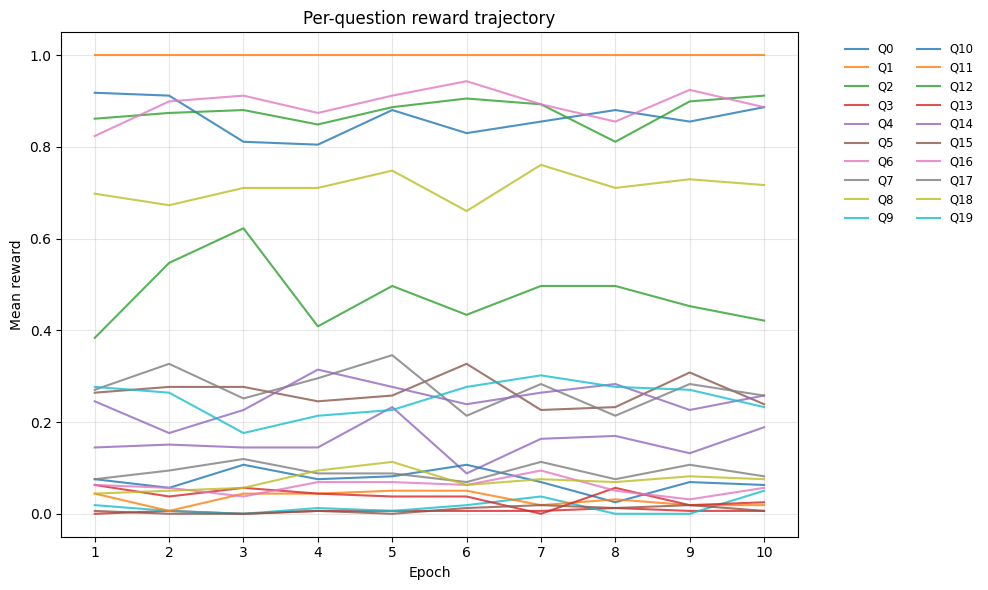

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- reshape rewards ---
# epoch_wide_rewards  -> shape (num_epochs, num_questions)
epoch_wide_rewards = [[item.item() for item in rewards] for rewards in epoch_wide_rewards]
reward_matrix = np.array(epoch_wide_rewards)       # (E, Q)
num_epochs, num_qs = reward_matrix.shape

# --- plot ---
plt.figure(figsize=(10, 6))
x = np.arange(1, num_epochs + 1)

for q in range(num_qs):
    plt.plot(x, reward_matrix[:, q], label=f"Q{q}", alpha=0.8)

plt.title("Per-question reward trajectory")
plt.xlabel("Epoch")
plt.ylabel("Mean reward")
plt.xticks(x)
plt.grid(alpha=0.3)

# put the legend outside so the graph isn’t cluttered
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left",
    ncol=2, fontsize="small", frameon=False
)

plt.tight_layout()
plt.show()

In [12]:
# ------------------------------------------------------------
# 0.  Imports & config – nothing here should clash with yours
# ------------------------------------------------------------
from tqdm import tqdm
import torch
from mathbert_encoder import MathBERTEncoder
import retriever_cosine as rc
# from import retrieve_top_k_cosine, retrieve_sample_k_cosine
from response_sampler import sample_responses_per_demo
from reward_aggregator import compute_demo_accuracy
from icl_model_wrapper import OpenAIICLModel
from grpo_optimizer import grpo_step
from datasets import load_dataset
from dotenv import load_dotenv
import os
from transformers import get_linear_schedule_with_warmup
from importlib import reload

reload(rc)

load_dotenv()

API_KEY = os.getenv("OPENAI_API_KEY")
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
K       = 3                # demos per query
NUM_SAMPLES = 5             # model completions per query
TEMPERATURE = 0.7           # keep same as training loop

# ------------------------------------------------------------
# 1.  Initialise encoder **in eval mode** (weights frozen)
# ------------------------------------------------------------
encoder.eval()                                   # no grads!

icl_model = OpenAIICLModel(api_key=API_KEY,
                           model_name="gpt-4.1-nano",
                           temperature=TEMPERATURE)

# ------------------------------------------------------------
# 2.  Load/define the inference set
#     If you already saved a slice elsewhere, just load it.
# ------------------------------------------------------------
gsm8k_data = load_dataset("gsm8k", "main")["train"].select(range(256))  # slice first 200 examples
gsm8k_to_infer = load_dataset("gsm8k", "main")["train"] \
                     .select(range(20))          # ⬅ change as needed

# ------------------------------------------------------------
# 3.  Evaluation loop
# ------------------------------------------------------------
total, correct = 0, 0
all_losses     = []          # optional – to compare prompt quality

for idx in tqdm(range(len(gsm8k_to_infer)), desc="Baseline eval"):
    item       = gsm8k_to_infer[idx]
    Q_inf, A_gt = item["question"], item["answer"]

    # Build demo pool (everything except current query)
    demos = [(d["question"], d["answer"])
             for j, d in enumerate(gsm8k_data) if j != idx]

    # Encode query + candidate demos
    with torch.no_grad():
        q_emb     = encoder.encode([Q_inf], detach=True).squeeze(0)
        demo_embs = encoder.encode([q for (q, _) in demos], detach=True)

    # ------- ORIGINAL cosine retrieval -------------------------
    top_k, _ = rc.retrieve_top_k_cosine(
        q_emb, demo_embs, k=min(K, len(demos))
    )
    print(f"🔍 Top-K Indices: {top_k}")
    selected_demos = [demos[i] for i in top_k]          # length = 2

    # ------- Run the ICL model --------------------------------
    responses_nested = sample_responses_per_demo(
        demo_tuples = selected_demos,
        Q_inf       = Q_inf,
        icl_model   = icl_model,
        num_samples = NUM_SAMPLES,
        parallel=True
    )
    print(responses_nested)
    flat_responses = [r for demo_resps in responses_nested for r in demo_resps]
    acc = compute_demo_accuracy(flat_responses, A_gt)
    print(acc) 
    correct += acc
    total   += 1

baseline_acc = correct / total
print(f"\n📊  Baseline accuracy on GSM8K_to_infer: {baseline_acc:.3%}")


Baseline eval:   0%|          | 0/20 [00:00<?, ?it/s]

🔍 Top-K Indices: [18, 15, 0]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:   5%|▌         | 1/20 [00:01<00:34,  1.83s/it]

[['72', '72', '72', '72', '48 + 24 = 72'], ['72', '72', '72', '72', '96'], ['72', '72', '72', '72', '72']]
0.9333333333333333
🔍 Top-K Indices: [101, 63, 194]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  10%|█         | 2/20 [00:02<00:25,  1.39s/it]

[['10', '$10', '10', '$10', '10'], ['10', '10', '10', '10', '10'], ['$10', '10', '10', '10', '10']]
1.0
🔍 Top-K Indices: [112, 228, 2]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  15%|█▌        | 3/20 [00:04<00:21,  1.27s/it]

[['50', '50', '25', '50', '50'], ['$35', '$55', '$35', '$55', '$55'], ['25', '25', '25', '25', '25']]
1.0
🔍 Top-K Indices: [13, 203, 93]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  20%|██        | 4/20 [00:05<00:19,  1.24s/it]

[['48', '36', '54', '48', '48'], ['36', '36', '48', '48', '54'], ['48', '48', '48', '48', '48']]
0.0
🔍 Top-K Indices: [93, 206, 145]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  25%|██▌       | 5/20 [00:06<00:20,  1.35s/it]

[['624', '624', '624', '624', '624'], ['624', '624', '624', '312', '3 * 2 * 2 * 52 = 624'], ['3 pages × 2 friends × 2 times per week × 52 weeks = 3 × 2 × 2 × 52 = 624', '3 pages per letter × 2 letters per week × 2 times per week = 3 × 2 × 2 = 12 pages per week.\n\nNumber of weeks in a year ≈ 52.\n\nTotal pages per year = 12 × 52 = 624', '3 pages per letter × 2 friends × 2 times per week × 52 weeks = 3 × 2 × 2 × 52 = 624', '3 pages × 2 friends × 2 times per week × 52 weeks = 3 × 2 × 2 × 52 = 624', '3 pages per letter × 2 friends × 2 times per week = 3 × 2 × 2 = 12 pages per week\n12 pages per week × 52 weeks = 12 × 52 = 624\n#### 624']]
0.9333333333333333
🔍 Top-K Indices: [51, 73, 105]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  30%|███       | 6/20 [00:09<00:23,  1.68s/it]

[['150', '105', '50', '85', '220'], ['Yellow = 10  \nPurple = 80% more than yellow = 10 + (80% of 10) = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen = 25% of yellow and purple = 25% of 28 = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35', 'Yellow flowers = 10  \nPurple flowers = 10 + 80% of 10 = 10 + 0.8 * 10 = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen flowers = 25% of (yellow + purple) = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35', 'Yellow = 10  \nPurple = 80% more than yellow = 10 + 0.80 × 10 = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen = 25% of yellow and purple = 0.25 × 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35', 'Yellow flowers = 10  \nPurple flowers = 10 + 80% of 10 = 10 + 0.8 * 10 = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen flowers = 25% of (yellow + purple) = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + gr

Baseline eval:  35%|███▌      | 7/20 [00:10<00:20,  1.60s/it]

[['16*2 + 8*2 = 32 + 16 = 48', '2*16 + 2*8 = 32 + 16 = 48', '16*2 + 8*2 = 32 + 16 = 48', '16+16+8+8=48', '16 + 16 + 8 + 8 = 48'], ['48', '16 + 16 + 8 + 8 = 48', '16 + 16 + 8 + 8 = 48', '48', '48'], ['56', '48', '48', '48', '48']]
0.9333333333333333
🔍 Top-K Indices: [226, 60, 58]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  40%|████      | 8/20 [00:14<00:28,  2.41s/it]

[['16', '8', '16', '8', '8'], ['8', '8', '8', '8', '8'], ['8', '16', '8', '16', '16']]
0.3333333333333333
🔍 Top-K Indices: [96, 100, 115]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  45%|████▌     | 9/20 [00:16<00:24,  2.20s/it]

[['$41', '$41', '$41', '$41', '$41'], ['$61', '$200 - ($30 + $46 + $38 + $11 + $18 + $16) = $200 - $159 = 41', '$87', '$41', '$41'], ['$41', '51', '61', '61', '61']]
0.6
🔍 Top-K Indices: [81, 55, 119]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  50%|█████     | 10/20 [00:18<00:20,  2.06s/it]

[['$405', '270', '$342.00', '$405', '$270'], ['$405.00', '$450.00', '$405.00', '$405.00', '$405.00'], ['$495', '$405', '$405', '$495', '$495']]
0.0
🔍 Top-K Indices: [11, 96, 100]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  55%|█████▌    | 11/20 [00:19<00:16,  1.88s/it]

[['423.5', '423.5', '423.5', '423.5', '847 / (2^2 + 2^1 + 2^0) = 847 / (4 + 2 + 1) = 847 / 7 = 121'], ['1', '42', '21', '211', '126'], ['423.5', '423.5', '423.5', '423.5', '423.5']]
0.2
🔍 Top-K Indices: [177, 226, 60]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  60%|██████    | 12/20 [00:23<00:19,  2.48s/it]

[['8', '4', '4', '10', '4'], ['4', '4', '4', '4', '4'], ['10', '10', '4', '10', '4']]
0.0
🔍 Top-K Indices: [182, 211, 190]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  65%|██████▌   | 13/20 [00:25<00:15,  2.25s/it]

[['70', '85', '85', '85', '75'], ['60 + (1/2 * 60 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + ( (1/2) * 60 - 5 ) = 60 + (30 - 5) = 60 + 25 = 85', '60 + ( (1/2) * 60 - 5 ) = 60 + (30 - 5) = 60 + 25 = 85', '60 + ( (1/2) * 60 - 5 ) = 60 + (30 - 5) = 60 + 25 = 85'], ['60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85']]
0.8666666666666667
🔍 Top-K Indices: [53, 181, 23]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  70%|███████   | 14/20 [00:26<00:12,  2.09s/it]

[['$30', '$30', '$30', '$30', '$30'], ['$40', '$30', '$30', '$30', '$10 + $5 + $20 = 35'], ['$30', '$30', '$30', '$30', '$30']]
0.06666666666666667
🔍 Top-K Indices: [3, 93, 157]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  75%|███████▌  | 15/20 [00:31<00:13,  2.70s/it]

[['3', '20 minutes per 8 pages, so per page: 20/8 = 2.5 minutes\nFor 120 pages: 120 × 2.5 = 300 minutes\nConvert minutes to hours: 300 ÷ 60 = 5\n\n5', '20 minutes / 8 pages = 2.5 minutes per page  \n120 pages * 2.5 minutes per page = 300 minutes  \n300 minutes ÷ 60 = 5 hours', '20 minutes / 8 pages = 2.5 minutes per page  \n120 pages * 2.5 minutes = 300 minutes  \n300 minutes / 60 = 5 hours', '20 minutes / 8 pages = 2.5 minutes per page  \n120 pages × 2.5 minutes = 300 minutes  \n300 minutes ÷ 60 = 5 hours'], ['20 hours', '20 hours', '20 hours', '20 hours', '30'], ['3', '3', '3', '3', '3']]
0.26666666666666666
🔍 Top-K Indices: [30, 86, 59]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  80%|████████  | 16/20 [00:32<00:09,  2.39s/it]

[['$24,250', '$2000 + ($6 x 500 x 5 x 20) x (2.5 - 1)', '$20,000', '$125,000', '$15000'], ['60000', 'Profit per DVD = 2.5 * 6 - 6 = 15 - 6 = 9 dollars\nNumber of DVDs sold in 20 weeks = 500 DVDs/day * 5 days/week * 20 weeks = 500 * 5 * 20 = 50,000 DVDs\nTotal profit = 50,000 * 9 = 450,000 dollars', 'Profit per DVD = (Selling price) - (Cost to make)  \nSelling price = 2.5 * $6 = $15  \nProfit per DVD = $15 - $6 = $9  \n\nNumber of DVDs sold in one day = 500  \nNumber of days in 20 weeks = 20 * 5 = 100  \n\nTotal DVDs sold in 20 weeks = 500 * 100 = 50,000  \n\nTotal profit from DVDs = 50,000 * $9 = $450,000  \n\nInitial movie creation cost = $2,000  \n\nTotal profit = $450,000 - $2,000 = $448,000', 'Profit per DVD = (Selling price) - (Cost to make) = (2.5 * 6) - 6 = 15 - 6 = 9 dollars\n\nNumber of DVDs sold per week = 500 * 5 = 2500\n\nProfit per week = 2500 * 9 = 22500 dollars\n\nProfit in 20 weeks = 20 * 22500 = 450000', 'Profit per DVD = (Selling price) - (Cost to make) = 2.5 * 6 - 6 

Baseline eval:  85%|████████▌ | 17/20 [00:34<00:06,  2.25s/it]

[['$1000', '$1000', "Mike's share = (2/7) * 2500 = 714.29  \nMike spends $200 on a shirt, remaining = 714.29 - 200 = 514.29", "Mike's share = (2/7) * 2500 = 714.2857...  \nMike's remaining amount after buying the shirt = 714.2857... - 200 ≈ 514.29", "Mike's share = \\( \\frac{2}{2+5} \\times 2500 = \\frac{2}{7} \\times 2500 = 714.29 \\)\n\nMoney Mike has after buying the shirt = 714.29 - 200 = 514.29"], ['1000', '1000', '1000', '1000', '$1000'], ['$1000', '700', '714.29', '1000', '500']]
0.0
🔍 Top-K Indices: [19, 204, 82]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  90%|█████████ | 18/20 [00:36<00:04,  2.09s/it]

[['56', '43', '26 - 4 - 6 = 16 pink hard hats remaining  \n15 - (2 × 6) = 15 - 12 = 3 green hard hats remaining  \n24 yellow hard hats remaining  \nTotal remaining = 16 + 3 + 24 = 43', '55', '26 - 4 - 6 = 16 (pink hard hats remaining)  \n15 - (2 * 6) = 15 - 12 = 3 (green hard hats remaining)  \n24 (yellow hard hats remaining)  \nTotal remaining = 16 + 3 + 24 = 43'], ['76', '26 - 4 - 6 = 16 pink hard hats remaining  \n15 - (2 * 6) = 15 - 12 = 3 green hard hats remaining  \n24 yellow hard hats remain unchanged  \nTotal hard hats remaining = 16 + 3 + 24 = 43', '26 - 4 (pink hard hats taken by Carl) = 22 pink hard hats remaining  \nJohn takes away 6 pink hard hats: remaining pink hard hats = 22 - 6 = 16  \nJohn takes away twice as many green hard hats as pink hard hats he took: 2 * 6 = 12 green hard hats taken  \nRemaining green hard hats: 15 - 12 = 3  \nYellow hard hats remain unchanged: 24  \nTotal remaining hard hats: 16 (pink) + 3 (green) + 24 (yellow) = 43', '26 - 4 - 6 = 16 pink hard

Baseline eval:  95%|█████████▌| 19/20 [00:37<00:01,  1.83s/it]

[['9', '9', '9', '9', '9'], ['9', '9', '9', '9', '9'], ['12', '12', '9', '10', '10']]
0.0
🔍 Top-K Indices: [18, 101, 119]
[INFO] Launching 15 parallel inference tasks...


Baseline eval: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]

[['6.4', '8', '12', '8', '12'], ['(5 * 20 miles * 2) + 200 miles = 200 + 200 = 400 miles  \nTime = Distance / Speed = 400 / 25 = 16 hours', 'Total miles biked in a week = (5 days * 2 * 20 miles) + 200 miles = 200 + 200 = 400 miles.  \nTime spent biking = Total miles / Speed = 400 miles / 25 mph = 16 hours.', '(5 days * 2 trips/day * 20 miles/trip) + 200 miles = 200 + 200 = 400 miles  \nTime = Distance / Speed = 400 miles / 25 mph = 16 hours', '25.6', 'Time for the 5 workdays: 2 trips per day * 5 days = 10 trips; each trip is 20 miles, so total miles = 10 * 20 = 200 miles.\nTime for work trips: 200 miles / 25 mph = 8 hours.\nTime for weekend ride: 200 miles / 25 mph = 8 hours.\nTotal time: 8 hours + 8 hours = 16 hours.'], ['8', '5 hours', '12', '8', '8']]
0.26666666666666666

📊  Baseline accuracy on GSM8K_to_infer: 42.333%


In [13]:
# Save the updated MathBERT model
save_path = "./53k_q3_iter_1_mathbert"  # your save directory
encoder.model.save_pretrained(save_path)
encoder.tokenizer.save_pretrained(save_path)

# LOADING

# from transformers import BertTokenizer, BertModel

# model = BertModel.from_pretrained("./updated_mathbert")
# tokenizer = BertTokenizer.from_pretrained("./updated_mathbert")


('./53k_q3_iter_1_mathbert/tokenizer_config.json',
 './53k_q3_iter_1_mathbert/special_tokens_map.json',
 './53k_q3_iter_1_mathbert/vocab.txt',
 './53k_q3_iter_1_mathbert/added_tokens.json')